In [1]:
cd '/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting'

/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting


In [47]:
# %load src/reg_model_class.py
import numpy as np
import pandas as pd

import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from scipy.interpolate import make_interp_spline
from src.data_clean_script import clean_data, replace_initial_values, replace_with_moving_averages, load_and_clean_data, create_spline, convert_to_date, fill_na_with_surround

from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib

from matplotlib.dates import (DAILY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)


class reg_model(object):
    def __init__(self, X, y, log_trans_y=False, day_cutoff=93):
        '''
        Day cutoff is split between training and testing data.
        '''
        self.X = X
        if log_trans_y == True:
            elim_invalid = y.copy()
            elim_invalid[elim_invalid < 0] = 0
            self.y = np.log(elim_invalid + 1)
        else:
            self.y = y
        if day_cutoff == 'auto':
            '''
            For grouped datasets that are normalized, this will take the minimum value of the maximums of each state for test set.

            '''
            day_cutoff = self.X.groupby('pop_density(t)')['days_elapsed(t)'].max().values.min()
        elif day_cutoff >= self.X['days_elapsed(t)'].max():
            day_cutoff = self.X['days_elapsed(t)'].max() - 10
        train_mask = self.X['days_elapsed(t)'] < day_cutoff
        holdout_mask = self.X['days_elapsed(t)'] >= day_cutoff
        self.log_trans_y = log_trans_y
        self.X_train, self.X_test, self.y_train, self.y_test = self.X[
            train_mask], self.X[holdout_mask], self.y[train_mask], self.y[holdout_mask]
        if len(self.X_test) == 0:
            # breakpoint()
            pass
        self.error_metric = None

    def lin_reg(self):
        self.model = LinearRegression()
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def log_reg(self):
        self.model = LogisticRegression()
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def ridge_reg(self, alpha=0.5):
        def optimize_alpha(alpha_list):
            pass
        self.model = Ridge(alpha=alpha)
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rss'

    def rand_forest(self, n_trees=100):
        '''
        Upon inspection of the model over time, the number of new cases shows a period of exponential growth, then linear growth where the new cases levels off. Then a random forest model can be applied. 
        '''
        if n_trees == 'optimize':
            '''
            If set to optimize, will take a selection of 1 to max_trees and uses number that minimizes error in training set.
            This can be plotted by uncommenting out the plt.plot(n, error) line.
            '''
            max_trees = 100
            n = np.arange(1, max_trees + 1, 1)
            error = []
            for each in n:
                self.model = RandomForestRegressor(
                    n_estimators=each, n_jobs=-1, random_state=1)
                self.model.fit(self.X_train, self.y_train)
                self.error_metric = 'rmse'
                error.append(self.evaluate_model())
            #plt.plot(n, error)
            n_trees = n[error.index(min(error))]
        # n_jobs = -1, random_state = 0, max_depth = 3, oob_score = False, random_state = 10
        self.model = RandomForestRegressor(
            n_estimators=n_trees, random_state=None)
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def evaluate_model(self, print_err_metric=False):
        try:
            self.y_hat = self.model.predict(self.X_test)
        except:
            breakpoint()
        self.predicted_vals_df = pd.DataFrame(self.y_test)
        self.predicted_vals_df['days_elapsed(t)'] = self.X_test['days_elapsed(t)']
        self.predicted_vals_df['y_hat'] = self.y_hat
        self.predicted_vals_df.sort_index(inplace=True)
        if self.error_metric == 'rmse':
            rmse = np.sqrt(mean_squared_error(self.y_test, self.y_hat))
            if print_err_metric:
                print('rmse:', rmse)
            return rmse
        elif self.error_metric == 'rss':
            rss = np.mean((self.y_test - self.y_hat)**2)
            if print_err_metric:
                print('rss: ', rss)
            return rss

    def forecast_vals(self, to_forecast_df):
        self.forecasted = self.model.predict(to_forecast_df)
        return self.forecasted

    def plot_model(self, use_smoothed=True, threshold=100, save_name=None, xvar='days_elapsed(t)', convDate=True):
        '''
        Use smoothed generates data using moving average. 
        Convdate converts days elapsed into date
        '''
        register_matplotlib_converters()
        fig, ax = plt.subplots(figsize=(10, 6))
        if self.log_trans_y == True:
            self.y_test = np.e ** self.y_test
        ax.bar(self.X_test.loc[:, xvar].apply(convert_to_date),
               self.y_test, color='blue', label="Test Data")
        ax.bar(self.X_train.loc[:, xvar].apply(convert_to_date),
               self.y_train, color='red', label="Training Data")
        if use_smoothed == True:
            x, y = create_spline(self.X[xvar], self.y, day_delay=0)
            x = pd.DataFrame(x).iloc[:, 0].apply(convert_to_date)
            ax.plot_date(x, y, c='green', label='Moving Average - 7 days',
                         xdate=True, marker='', ls='-')
            fig.autofmt_xdate()

            rule = rrulewrapper(DAILY, interval=7)
            loc = RRuleLocator(rule)
            formatter = DateFormatter('%y/%m/%d')
            ax.xaxis.set_major_locator(loc)
            ax.xaxis.set_major_formatter(formatter)
            ax.xaxis.set_tick_params(rotation=30, labelsize=14)
            ax.set_xlabel('Date')
        else:
            x = self.X_test
            y = self.y
            ax.plot(self.X_test.loc[:, xvar],
                    self.y_test, c='green', label='Predicted Data')
            ax.set_xlabel('Days Since Feb 15')
        try:
            x_thresh = convert_to_date(x[np.where(np.e**y >= threshold)[0][0]])
            ax.axvline(x_thresh, label='Threshold', color='black', ls='--')
        except:
            pass
        ax.legend()
        ax.set_ylabel('Daily Cases per 1 Million Population')
        ax.set_title('New York COVID-19 New Cases')
        fig.tight_layout()
        if save_name != None:
            fig.savefig('images/{}'.format(save_name))


In [48]:
# %load src/data_clean_script.py
import pandas as pd
import numpy as np
import datetime

def create_spline(x, y, day_delay, t=7):
    '''
    Use moving average of t points at day_delay
    '''
    y_raw = y.values if day_delay == 0 else y.values[:-day_delay]
    weights = np.repeat(1.0, t) / t
    mov_avgs_y = np.convolve(y_raw, weights, 'valid')
    mov_avgs_x = list(
        range(int(x.values[0] + t + day_delay), int(x.values[-1] + 2)))
    return mov_avgs_x, mov_avgs_y[:len(mov_avgs_x) + 1]


def clean_data(df, datetime_col=None):
    clean_df = df.copy()
    if datetime_col != None:
        clean_df[datetime_col] = pd.to_datetime(clean_df[datetime_col])
    return clean_df


def convert_to_date(days_elapsed, original_date=datetime.date(2020, 2, 15)):
    date_result = original_date + datetime.timedelta(days_elapsed)
    return date_result


def replace_initial_values(df, col_change, val_col):
    '''
    When creating new feature columns using difference of existing columns, this function will replace the initial value in val_col of col_change with a 0.
    '''
    prev = None
    for i, st in zip(df.index, df[col_change]):
        if st != prev:
            df.loc[i, val_col] = 0
        else:
            continue
        prev = st
    return df


def replace_with_moving_averages(df, cols, day_delay, xcol='days_elapsed'):
    '''
    Replaces applicable rows  in columns with weekly average days_past days ago.
    Day delay is an optional parameter if we want to set the moving average to the weekly moving average x number of days ago.

    '''
    df_ma = df.copy()
    for col in cols:
        max_index = max(df_ma.index)
        mv_avgs = create_spline(
            df_ma[xcol], df_ma[col], day_delay=day_delay)[1]
        applicable_row_indices = max_index - len(mv_avgs) + 1
        df_ma.loc[applicable_row_indices:, col] = mv_avgs
    return df_ma


def load_and_clean_data(new_cases_per_pop=True):
    '''
    Arguments: new_cases_per_pop = True
    Sets up and generates dataframe for analysis 
    If new cases per pop is disabled, will use raw number of new cases instead.
    '''

    #Import and clean covid data (Cases in 2020)
    covid_raw_df = pd.read_csv('data/covid-19-data/us-states.csv')
    covid_df = clean_data(covid_raw_df, datetime_col='date')
    covid_df.sort_values(['state', 'date'], inplace=True)
    covid_df['New_Cases'] = covid_df['cases'].diff()

    covid_df = replace_initial_values(covid_df, 'state', 'New_Cases')

    '''
    Mobility Data - From Google
    #The baseline is the median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020
    https://www.google.com/covid19/mobility/index.html?hl=en
    '''

    mobility_raw_df = pd.read_csv(
        'data/Global_Mobility_Report.csv', low_memory=False)
    US_mobility_raw_df = mobility_raw_df[(mobility_raw_df['country_region'] == 'United States') & (
        mobility_raw_df['sub_region_1'].isnull() == False) & (mobility_raw_df['sub_region_2'].isnull() == True)]
    mobility_df = clean_data(US_mobility_raw_df, datetime_col='date')
    mobility_df.reset_index(inplace=True)
    mobility_df.drop(['index', 'country_region_code',
                      'country_region', 'sub_region_2'], axis=1, inplace=True)
    mobility_df.rename(columns=lambda x: x.replace(
        '_percent_change_from_baseline', ''), inplace=True)
    mobility_df.rename(columns={'sub_region_1': 'state'}, inplace=True)
    num_cols = ['retail_and_recreation', 'grocery_and_pharmacy',
                'parks', 'transit_stations', 'workplaces', 'residential']
    mobility_df[num_cols] = mobility_df[num_cols].apply(pd.to_numeric)

    #Convert to percent of normal
    mobility_df[num_cols] = mobility_df[num_cols].apply(
        lambda x: (x + 100)/100)
    states = list(set(mobility_df['state']))
    '''
    Transp data - From Apple
    The CSV file and charts on this site show a relative volume of directions requests per country/region, sub-region or city compared to a baseline volume on January 13th, 2020. We define our day as midnight-to-midnight, Pacific time.
    https://www.apple.com/covid19/mobility 
    '''
    transp_raw_df = pd.read_csv('data/applemobilitytrends-2020-06-01.csv')
    transp_df = transp_raw_df[(transp_raw_df['geo_type'] == 'sub-region')
                              & (transp_raw_df['region'].isin(states))].copy()
    #Driving is only available transportation type data available for statewide data
    transp_df.drop(['geo_type', 'alternative_name', 'transportation_type', 'sub-region', 'country'],
                   axis=1, inplace=True)
    transp_df.set_index('region', inplace=True)
    transp_df = (transp_df.T) / 100  # Convert to percentage of normal
    transp_df.reset_index(inplace=True)
    transp_df.rename(columns={'index': 'date'}, inplace=True)
    transp_df['date'] = pd.to_datetime(transp_df['date'])
    transp_df = transp_df.melt(id_vars=["date"])
    transp_df.rename(columns={'region': 'state'}, inplace=True)

    mobility_df = mobility_df.merge(
        transp_df, how='inner', on=['date', 'state'])
    covid_df = mobility_df.merge(covid_df, how='inner', on=['date', 'state'])
    covid_df.rename(columns={'value': 'driving'}, inplace=True)
    covid_df.drop(['cases', 'deaths', 'fips'], axis=1, inplace=True)

    #Converts date into days elapsed since outbreak- some functions don't work with datetime objects
    #February 15th is earliest data
    min_date = datetime.datetime(2020, 2, 15)
    covid_df['date'] = covid_df['date'].apply(
        lambda x: (x.to_pydatetime() - min_date).days)
    dates = covid_df['date']
    covid_df.rename(columns={'date': 'days_elapsed'}, inplace=True)

    #Importing state populations and land areas - going to convert cases to new cases per capita for better comparison, implement state density
    state_pops = pd.read_csv('data/pop_by_state.csv',
                             header=1, usecols=['State', 'Pop'])
    state_area = pd.read_csv('data/state_area.csv',
                             usecols=['State', 'LandArea'])
    state_pops.rename(columns={'State': 'state'}, inplace=True)
    state_area.rename(columns={'State': 'state'}, inplace=True)
    state_pops = state_pops.merge(state_area, on='state')
    state_pops['pop_density'] = state_pops['Pop'] / state_pops['LandArea']

    if new_cases_per_pop == True:
        state_pops['Pop'] = state_pops['Pop'] / 1000000
        covid_df = covid_df.merge(state_pops, on='state')
        covid_df['New_Cases_per_pop'] = covid_df['New_Cases'] / covid_df['Pop']
        covid_df.drop(['LandArea', 'Pop'], axis=1, inplace=True)
        covid_df.drop(['New_Cases'], axis=1, inplace=True)

    #2 missing park values; manually fill them in with average of surrounding value
    missing_parks_ind = [507, 514, 661, 668,
                         675, 682, 689, 1017, 1024, 1031, 2940]
    covid_df = fill_na_with_surround(
        covid_df, 'parks', series=missing_parks_ind)
    return covid_df


def fill_na_with_surround(df, col, series=True, ind_loc='iloc'):
    '''
    Can be used to fill NA values with the average of the two surrounding values in a series of missing values,
    or standalone value (specified with series argument).
    Note: Currently only tested if one continuous series of non numeric values exists in the specified col.
    Assumes valid value exists after the series of NaNs.
    '''
    indices = df[df[col].isnull()].index.values
    if len(indices) != 0:
        if series == True:
            if ind_loc == 'iloc':
                val_1 = df[col].iloc[min(indices) - 1]
                val_2 = df[col].iloc[max(indices) + 1]
            else:
                val_1 = df[col].loc[min(indices) - 1]
                val_2 = df[col].loc[max(indices) + 1]
            replace = (val_1 + val_2) / 2
            df[col].fillna(replace, inplace=True)
        else:
            for row in series:
                df.loc[row, col] = (df.loc[row - 1, col] +
                                    df.loc[row + 1, col]) / 2
    return df

def get_moving_avg_df(covid_df, state):
    mask1 = (covid_df['state'] == state)
    state_df = covid_df[mask1]
    y = state_df.pop('New_Cases_per_pop')
    X = state_df.iloc[:, 1: -1]

    #Calculate moving average, use as target variable instead of raw new cases/pop
    smooth_x, smooth_y = create_spline(X['days_elapsed'], y, day_delay=0)
    if len(smooth_x) == 0 or len(smooth_y) == 0:
        breakpoint()
    mov_avg_df = pd.DataFrame([smooth_x, smooth_y]).T
    mov_avg_df.columns = ('days_elapsed', 'Daily_Cases_per_pop')
    state_df = replace_with_moving_averages(
        state_df, state_df.columns[2:-1], day_delay=10)

    revised_df = state_df.merge(mov_avg_df, on='days_elapsed').iloc[:, 1:]
    fill_na_with_surround(revised_df, 'driving')
    return revised_df


In [49]:
# %load src/State_Comparison.py
from src.reg_model_class import reg_model
from src.data_clean_script import clean_data, replace_initial_values, replace_with_moving_averages, load_and_clean_data, create_spline, convert_to_date, fill_na_with_surround, get_moving_avg_df
from src.Misc_functions import series_to_supervised, generate_prediction_df, normalize_days

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters

import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker

class Comparable_States(object):
    '''
    To get predictions on a state, similar states in population density  will be needed to compare. Use the
    non-moving average covid_df for import - a moving average will be applied automatically.
    This class generates and stores a dataframe of states, population densities, and Recovery Factor*
    '''

    def __init__(self):
        self.master_pop_density_df = self.make_master_pop_dens_df()

    def make_master_pop_dens_df(self, most_recent_day=104):
        covid_df = load_and_clean_data()
        all_states = covid_df['state'].unique()
        pop_density = covid_df[['state', 'pop_density']].drop_duplicates()
        pop_density_df = pop_density.set_index('state')
        self.master_covid_df = pd.DataFrame(
            get_moving_avg_df(covid_df, state=all_states[0]))
        self.master_covid_df['state'] = all_states[0]
        for state in all_states[1:]:
            state_df = get_moving_avg_df(covid_df, state=state)
            state_df['state'] = state
            self.master_covid_df = self.master_covid_df.append(state_df)
        self.master_covid_df.rename(
            columns={'Daily New Cases': 'Daily New Cases (mv avg)'}, inplace=True)

        max_cases = self.master_covid_df[[
            'state', 'Daily New Cases (mv avg)']].groupby('state').max()
        recent_cases = self.master_covid_df[self.master_covid_df['days_elapsed'] == most_recent_day][[
            'state', 'Daily New Cases (mv avg)']]  # .groupby('state').max()
        recent_cases['Daily New Cases (mv avg)'] = recent_cases['Daily New Cases (mv avg)'].where(
            recent_cases['Daily New Cases (mv avg)'] > 0.01, 0.01)
        recent_cases.set_index('state', inplace=True)
        recent_cases.drop_duplicates(inplace=True)

        Recovery_df = max_cases / recent_cases
        Recovery_df.rename(
            columns={'Daily New Cases (mv avg)': 'Recovery Factor'}, inplace=True)

        master_pop_density_df = pop_density_df.merge(
            Recovery_df, on='state').sort_values('pop_density')
        master_pop_density_df.sort_values('pop_density', inplace=True)
        self.master_pop_density_df = master_pop_density_df
        return self.master_pop_density_df

    def get_similar_states(self, state_to_predict, recovery_factor_min=1.2, pop_density_tolerance=25):
        self.state_to_predict = state_to_predict
        '''
        Recovery Factor is a measure of how well the state has recovered from the pandemic, measured as the greatest
        number of 7 day moving averages of new cases divided by the most recent 7 day moving average.
        Will return states that exceed this number and plus or minus the specified popululation density difference
        to compared state.
        
        Can be called automatically using pre-defined parameters by specifying state when initializing. To specify
        parameters, must be called on objects with them specified after initialization.
        '''
        state_pop_dens = self.master_pop_density_df.loc[state_to_predict, 'pop_density']
        mask1 = self.master_pop_density_df['pop_density'] > state_pop_dens - \
            pop_density_tolerance
        mask2 = self.master_pop_density_df['pop_density'] < state_pop_dens + \
            pop_density_tolerance
        mask3 = self.master_pop_density_df['Recovery Factor'] > recovery_factor_min
        return self.master_pop_density_df[mask1 & mask2 & mask3]


class Combined_State_Analysis(reg_model):
    '''
    Provide list of state_dfs to combined into one model to create a dataset for training. Use the Comparable_States
    class to generate similar states for better results before calling predictions class.
    '''

    def __init__(self, state_list, print_err=False, normalize_day = False):
        register_matplotlib_converters()
        covid_df = load_and_clean_data()
        if normalize_day == True:
            state_dfs = normalize_days(state_list, covid_df)
            new_df = state_dfs[0]
            if len(state_dfs) > 0:
                new_df.append([each_df for each_df in state_df[1:]])
            covid_df = new_df
            breakpoint()
        self.state_list = state_list
        X_df_list = [state_analysis(covid_df, state=state, print_err=False)[
            1] for state in state_list]
        y_df_list = [state_analysis(covid_df, state=state, print_err=False)[
            2] for state in state_list]
        if len(X_df_list) == 1:
            self.X = X_df_list[0]
            self.y = y_df_list[0]
        else:
            self.X = X_df_list[0].append(X_df_list[1:])
            self.y = y_df_list[0].append(y_df_list[1:])

        self.rf = reg_model(self.X, self.y)
        self.rf.rand_forest()
        self.evaluate = self.rf.evaluate_model(print_err_metric=print_err)

    def print_err(self, print_err):
        self.rf.evaluate_model(print_err=True)

    def get_feature_importances(self):
        features = self.rf.X.columns
        feature_importances = self.rf.model.feature_importances_
        return pd.DataFrame(feature_importances, index=features)


class Predictions(Combined_State_Analysis):
    '''
    Use results from Comparable_States and Combined_State_Analysis to come up with predictions for state
    '''

    def __init__(self, covid_df, state_to_predict, similar_states, Comb_St_Analysis, normalize = False):
        self.state = state_to_predict
        self.similar_states = similar_states
        self.State_Compile = Comb_St_Analysis
        self.similar_df = Comb_St_Analysis.X.copy()
        self.similar_df['Daily New Cases'] = Comb_St_Analysis.y

        self.pop_densities = self.similar_df['pop_density(t)'].unique()
        self.State_Analysis_X, self.State_Analysis_y = state_analysis(
            covid_df, state=state_to_predict, print_err=False)[1], state_analysis(
            covid_df, state=state_to_predict, print_err=False)[2]

    def get_social_distancing_estimates(self, analysis=False):
        '''
        This method gets the minimum and maximum social distancing levels for all states in the training set based
        on the maximum and minimum amounts observed on the training interval.
        '''
        min_vals = self.similar_df.min(
        ).loc['retail_and_recreation(t)':'driving(t)']
        max_vals = self.similar_df.max(
        ).loc['retail_and_recreation(t)':'driving(t)']
        max_SD = list(min_vals[:5])
        max_SD.extend([max_vals[5], min_vals[6]])
        min_SD = list(max_vals[:5])
        min_SD.extend([min_vals[5], max_vals[6]])
        if analysis == False:
            return min_SD, max_SD
        if analysis == True:
            high, low = max_SD, min_SD
            columns = ['Retail/Recreation %', 'Grocery/Pharmacy %', 'Parks %',
                       'Transit Stations %', 'Workplaces %', 'Residential %', 'Driving %']
            SD_Table = round(pd.DataFrame(
                [np.array(high), np.array(low)], columns=columns) * 100, 2)
            SD_Table[''] = ['High', 'Low']
            SD_Table.set_index('', inplace=True)
            return SD_Table

    def plot_similar_states(self, save=None):
        fig, ax = plt.subplots(figsize=(14, 7))
        for i, pop_density in enumerate(self.pop_densities):
            state_df = self.similar_df[self.similar_df['pop_density(t)']
                                       == pop_density]
            x = state_df.loc[:, 'days_elapsed(t)']
            y = state_df.loc[:, 'Daily New Cases']
            ax.plot(x.apply(convert_to_date), y,
                    label=self.similar_states[i])
        x = self.State_Analysis_X['days_elapsed(t)'].apply(convert_to_date)
        y = self.State_Analysis_y.values
        ax.plot(x.values, y, label=self.state, ls='--')
        ax.axvline(convert_to_date(93), linestyle='-.', lw='0.7',
                color='black', label='Train/Test Split')
        ax.legend()
        ax.set_title(
            'States Similar to {} in Population Density'.format(self.state))
        ax.set_xlabel('Date')
        ax.set_ylabel('New Cases/Day Per 1M Pop')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
        fig.autofmt_xdate(rotation=30)
        fig.tight_layout()
        if save != None:
            fig.savefig(save)

    def plot_pred_vs_actual(self, save=None):
        fig, ax = plt.subplots(figsize=(14, 7))
        ax.plot(self.State_Analysis_X['days_elapsed(t)'].apply(
            convert_to_date), self.State_Compile.rf.model.predict(self.State_Analysis_X), label='Model Predictions')
        ax.plot(self.State_Analysis_X['days_elapsed(t)'].apply(
            convert_to_date), self.State_Analysis_y.values, label='Actually  Observed')
        ax.set_ylim(0)
        ax.legend()
        ax.set_title('Model Performance for {}'.format(self.state))
        ax.set_xlabel('Date')
        ax.set_ylabel('New Cases/Day Per 1M Pop')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
        fig.autofmt_xdate(rotation=30)
        fig.tight_layout()
        if save != None:
            fig.savefig(save)

    def forecast_to_future(self, save=None):
        min_SD, max_SD = self.get_social_distancing_estimates()
        high_pred = generate_prediction_df(
            max_SD, self.State_Analysis_X, self.State_Analysis_y, predictions=21, rf=self.State_Compile.rf)
        fig, ax = plt.subplots(figsize=(14, 7))
        labels = ['High Social Distancing', 'Low Social Distancing']
        x = high_pred[0]['days_elapsed(t)']
        y = high_pred[1]
        x = x[2:]
        ax.plot(x[x <= 103].apply(convert_to_date), y[:len(x[x <= 103])], label = 'Past Data', c = 'black')
        ax.plot(x[x >= 103].apply(convert_to_date), y[-len(x[x >= 103]):], label= 'High Social Distancing')

        low_pred = generate_prediction_df(
            min_SD, self.State_Analysis_X, self.State_Analysis_y, predictions=21, rf=self.State_Compile.rf)
        x = low_pred[0]['days_elapsed(t)']
        y = low_pred[1]
        ax.plot(x[x >= 103].apply(convert_to_date),
                y[-len(x[x >= 103]):], label='Low Social Distancing')

        ax.legend()
        ax.set_title('Future Predicted Daily New Cases'.format(self.state))
        ax.set_xlabel('Date')
        ax.set_ylabel('New Cases/Day Per 1M Pop')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
        fig.autofmt_xdate(rotation=30)
        fig.tight_layout()
        if save != None:
            fig.savefig(save)

def state_analysis(covid_df, state='New York', print_err=False):
    '''
    Produces random forest model for specified state, returns tuple of model and time series dataframe
    Note: This class is intended for loading training data, use other_state class 
    from State_Comparison.py for prediction and insights on other states
    '''
    revised_df = get_moving_avg_df(covid_df, state=state)
    #Create time series dataframe, fit it into model and evaluate
    values = revised_df.values
    num_cols = len(revised_df.columns)
    ts_frame_data = series_to_supervised(values, revised_df.columns, 21, 1)
    ts_frame_data = ts_frame_data.iloc[:,
                                        num_cols-1:-num_cols + 1:num_cols].join(ts_frame_data.iloc[:, -num_cols:])
    ts_frame_data.index.name = state
    ts_y = ts_frame_data.pop('Daily New Cases(t)')
    ts_x = ts_frame_data
    rf_model = reg_model(ts_x, ts_y)
    rf_model.rand_forest(n_trees=100)
    rf_model.evaluate_model(print_err_metric=print_err)
    return rf_model, ts_x, ts_y


In [50]:
# %load src/Misc_functions.py
from src.data_clean_script import replace_with_moving_averages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def fill_diagonals(df, preds, model, start_row=31, n_interval=21):
    df.fillna(0, inplace=True)
    n_rows = df.shape[0]
    new_preds = list(preds.values)
    for row in range(start_row, n_rows)[:]:
        new_pred = model.predict(df[row:row + 1])[0]
        new_preds.append(new_pred)
        j = 0
        for col in range(n_interval-1, 0, -1):
            try:
                if df.iloc[row + j, col] == 0:
                    df.iloc[row + j, col] = new_pred
                j += 1
            except:
                continue
    new_pred = model.predict(df[-1:-2:-1])[0]
    new_preds.append(new_pred)
    return df, new_preds

def generate_prediction_df(level, total_x, total_y, rf, predictions=21):

    #Part 1: Expands time lagged Daily New Cases columns

    columns = ['days_elapsed(t)', 'retail_and_recreation(t)', 'grocery_and_pharmacy(t)',
               'parks(t)', 'transit_stations(t)', 'workplaces(t)', 'residential(t)', 'driving(t)', 'pop_density(t)']

    levelDict = {'High': [0.34, 0.5, 0.36, 0.295, 0.4, 1.3, 0.385],
                 'Medium': [0.6, 0.8, 0.7, 0.7, 0.75, 1.1, 0.7],
                 'Low': [1, 1, 1, 1, 1, 0.9, 1]
                 }
    if type(level) != str:
        pred_params = level
    else:
        pred_params = levelDict[level]
    pred_df = total_x.copy()
    last_recorded_day = int(pred_df['days_elapsed(t)'].max())
    pop_dens = pred_df['pop_density(t)'].mode().iloc[0]
    for i in range(last_recorded_day + 1, last_recorded_day + predictions + 1):
        pred_df_row = pd.DataFrame([i] + pred_params + [pop_dens]).T
        pred_df_row.columns = columns
        pred_df = pred_df.append(pred_df_row, sort=False)

    y_pred = total_y

    # Part 2: Fills in blank known new cases values
    n_rows = pred_df.shape[0]
    pred_df.fillna(0, inplace=True)
    row_start = pred_df.shape[0] - \
        pred_df[pred_df['Daily New Cases(t-1)'] == 0].count()[0]
    col_start = 20
    new_preds = list(y_pred.values)
    pred_df.iloc[row_start, col_start] = y_pred.values[-1]
    for row in range(row_start, n_rows):
        for col in range(col_start - 1, -1, -1):
            pred_df.iloc[row, col] = pred_df.iloc[row - 1, col + 1]

    #Part 3: Fills in rest of time lagged values for future t values, predicting based on prior predictions
    fill_diag_and_predictions = fill_diagonals(
        pred_df, y_pred.loc[:45], rf.model, start_row=row_start, n_interval=21)
    pred_df = fill_diag_and_predictions[0]
    pred_y = fill_diag_and_predictions[1][-pred_df.shape[0]:]
    return pred_df, pred_y


def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

def normalize_days(states, covid_df, percent_max=0.25, plot=False, save_x_starts = False):
    '''
    Process covid_df day elapsed column into days elapsed since hitting percent_max of its maximum number of cases/person.
    save_x_starts will return a tuple to translate back into actual date later.

    '''
    state_dfs = []
    x_starts = []
    if plot == True:
        colors = ['red', 'blue', 'green', 'black', 'violet', 'orange']
        fig, ax = plt.subplots(figsize=(12, 6))
    for i, state in enumerate(states):
        raw = covid_df[covid_df['state'] == state]
        df = replace_with_moving_averages(raw, ['New_Cases_per_pop'], 0)
        x = df['days_elapsed']
        y = df['New_Cases_per_pop']
        y_start = max(y) * percent_max
        y_idx = find_nearest(y.values, y_start)
        x_start = x[y == y.iloc[y_idx]].values[0]
        df['days_elapsed'] = df['days_elapsed'] - x_start
        df.rename(columns = {'days_elapsed': 'days_since_start'}, inplace = True)

        if plot == True:
            plt.plot(df['days_since_start'], y, c=colors[i], label=state)
#             ax.axhline(y_start, c=colors[i], lw=2, ls='-.')
            ax.set_title('Day Normalization Plot')
            ax.legend()
        state_dfs.append(df)
        x_starts.append(x_start)
    if save_x_starts == True:
        return x_starts, state_dfs
    return state_dfs



In [51]:
# %load src/main.py
'''
See notebooks/EDA.ipynb for plots

Import scripts from other .py files
'''
from src.State_Comparison import Comparable_States, Combined_State_Analysis, state_analysis, Predictions
from src.reg_model_class import reg_model
from src.data_clean_script import clean_data, replace_initial_values, replace_with_moving_averages, load_and_clean_data, create_spline, convert_to_date, fill_na_with_surround, get_moving_avg_df
from src.Misc_functions import series_to_supervised, generate_prediction_df, normalize_days

import pandas as pd
import numpy as np
import datetime

from scipy.interpolate import make_interp_spline

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({'font.size': 16})
plt.style.use('fivethirtyeight')
plt.close('all')

#Define minimum threshold of cases per 1 million people in each state to begin training data on.
#Threshold is the minimum value at which data is output; Used to reduce misleading predictions
#(low new cases count and low social distancing parameters before pandemic)
threshold = 450

def state_plot(state, df):
    fig, axes = plt.subplots(8, 1, figsize=(12, 15))
    for i, ax in enumerate(axes, 2):
        query = df[df['state'] == state]['days_elapsed']
        x = query.values
        y = covid_df.loc[query.index].iloc[:, i]
        ax.plot(x, y)
    fig.show()

if __name__ == '__main__':
    state = 'Minnesota'

    covid_df = load_and_clean_data()
    Similar_States_Init = Comparable_States()
    Similar_States_Init.make_master_pop_dens_df()
    sim_states_df = Similar_States_Init.get_similar_states(
        state_to_predict=state, recovery_factor_min=1.2, pop_density_tolerance=25)
    similar_states = sim_states_df.index.values
    State_Compile = Combined_State_Analysis(similar_states, print_err=True, normalize_day = True)
    State_Compile.get_feature_importances().T
    print("The Most similar states to {} that meet the comparable parameters are: {}. These will be used to predict for {}.".format(
        state, similar_states, state))

    Prediction_Insights = Predictions(covid_df, state, similar_states, State_Compile, normalize = True)
    #Plots in notebooks/EDA.ipynb


rmse: 19.086005607081294
The Most similar states to Minnesota that meet the comparable parameters are: ['Colorado' 'Iowa' 'Oklahoma' 'Vermont' 'Missouri']. These will be used to predict for Minnesota.


In [7]:
state_list = Prediction_Insights.similar_states
similar_to_MN_df = Prediction_Insights.similar_df.drop_duplicates()

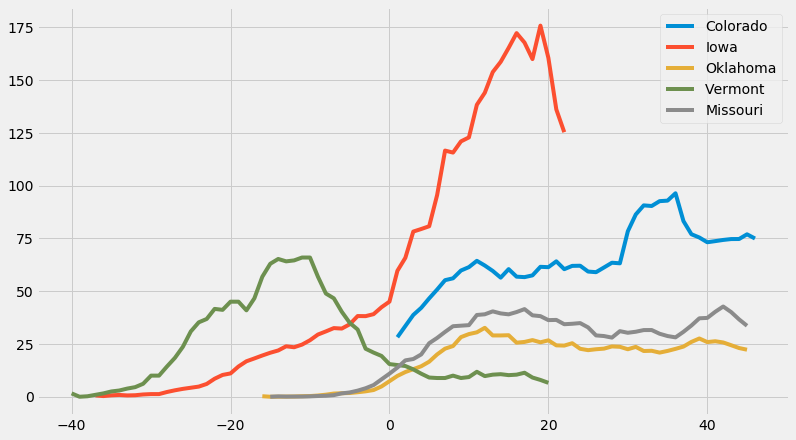

In [8]:

fig, ax = plt.subplots(figsize = (12, 7))
i = 0
for each in similar_to_MN_df['pop_density(t)'].unique():
    sub_df = similar_to_MN_df[similar_to_MN_df['pop_density(t)'] == each].copy()
    sub_df.sort_values(['days_elapsed(t)'], inplace = True)
    x = sub_df['days_elapsed(t)'].values
    y = sub_df['New_Cases_per_pop(t)'].values
    ax.plot(x, y, label = state_list[i])
    i += 1
ax.legend()

In [9]:
indices = similar_to_MN_df[similar_to_MN_df['pop_density(t)'] == similar_to_MN_df['pop_density(t)'].unique()[3]]['days_elapsed(t)'].index
similar_to_MN_df['days_elapsed(t)'].loc[indices] += 30

/Users/jbud/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
MN_df = covid_df[covid_df['state'] == 'Minnesota']
IA_df = covid_df[covid_df['state'] == 'Iowa']
MN_df = replace_with_moving_averages(MN_df, ['New_Cases_per_pop'], 0)
IA_df = replace_with_moving_averages(IA_df, ['New_Cases_per_pop'], 0)

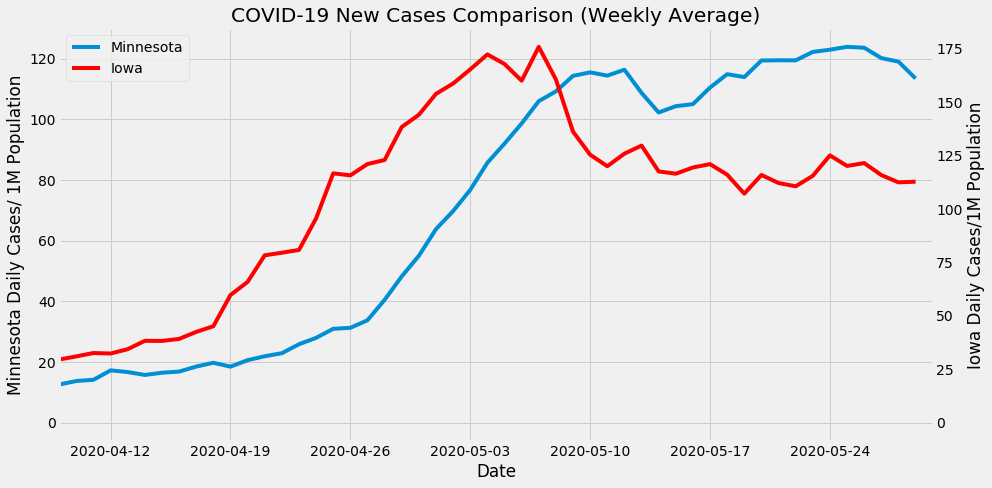

In [11]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize = (14, 7))
x = MN_df['days_elapsed']
y = MN_df['New_Cases_per_pop']
ax.plot(x.apply(convert_to_date), y, label = 'Minnesota')
ax.set_ylabel('{} Daily Cases/ 1M Population'.format('Minnesota'))
ax.set_xlim(convert_to_date(54), convert_to_date(105))
ax.set_xlabel('Date')
ax.set_title('COVID-19 New Cases Comparison (Weekly Average)')
x = IA_df['days_elapsed']
y = IA_df['New_Cases_per_pop']

ax2 = ax.twinx()
ax2.plot(x.apply(convert_to_date), y, label = 'Iowa', c = 'red')
ax2.set_ylabel('{} Daily Cases/1M Population'.format('Iowa'))
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1 + h2, l1 + l2, loc = 2)
ax2.grid(None)
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
fig.tight_layout()
fig.savefig('images/MN_IA')


In [12]:
states = ['Vermont']
x_starts, VT_df = normalize_days(states, covid_df, percent_max = 0.25, plot = False, save_x_starts = True)
VT = VT_df[0]
VT['days_since_start'] += 30
# plt.plot(VT_df['days_since_start'].values, VT_df['New_Cases_per_pop'].values)

Text(0, 0.5, 'Daily New Cases per 1M Pop')

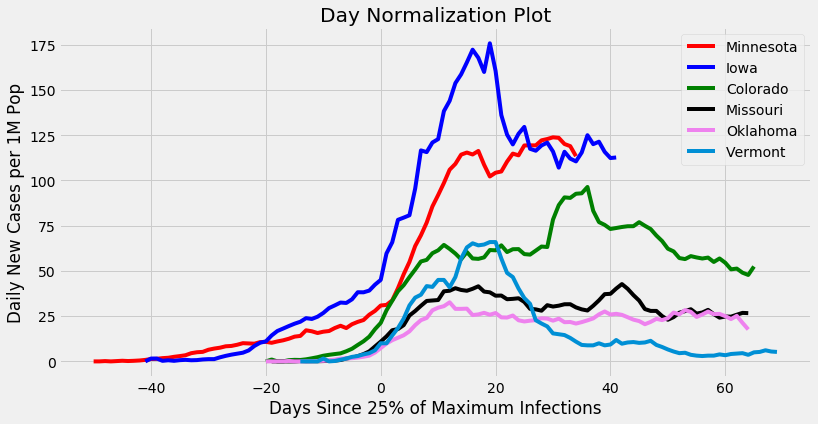

In [13]:
import numpy as np

states = ['Minnesota', 'Iowa', 'Colorado', 'Missouri', 'Oklahoma']

x_starts, df = normalize_days(states, covid_df, percent_max = 0.25, plot = True, save_x_starts = True)
plt.plot(VT['days_since_start'].values, VT['New_Cases_per_pop'].values, label = 'Vermont')
plt.legend()
plt.xlabel('Days Since 25% of Maximum Infections')
plt.ylabel('Daily New Cases per 1M Pop')

In [14]:
x_starts

[70, 63, 39, 40, 40]

In [15]:
normalized_df = VT.copy()
normalized_df = normalized_df.append(df)

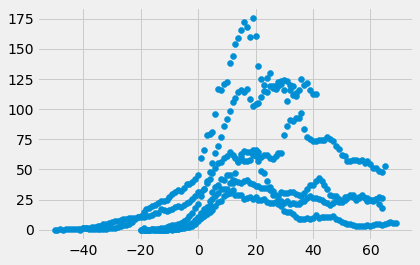

In [16]:
plt.scatter(normalized_df['days_since_start'], normalized_df['New_Cases_per_pop'])

In [17]:
normalized_df.drop('state', axis = 1, inplace = True)

In [18]:
values = normalized_df.values
num_cols = len(normalized_df.columns)
ts_frame_data = series_to_supervised(values, normalized_df.columns, 21, 1)
ts_frame_data = ts_frame_data.iloc[:,
                                    num_cols-1:-num_cols + 1:num_cols].join(ts_frame_data.iloc[:, -num_cols:])
ts_frame_data = ts_frame_data[ts_frame_data['days_since_start(t)'] >= 10]
ts_y = ts_frame_data.pop('New_Cases_per_pop(t)')
ts_x = ts_frame_data

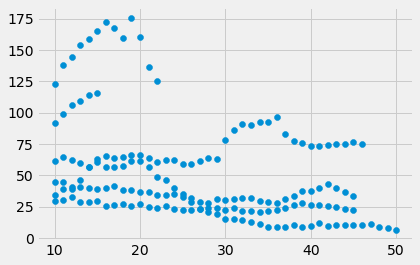

In [19]:
plt.scatter(ts_x['days_since_start(t)'], ts_y)

In [20]:
ts_x.rename(columns = {'days_since_start(t)' : 'days_elapsed(t)'}, inplace = True)

In [21]:
rf_model = reg_model(ts_x, ts_y)
rf_model.rand_forest(n_trees = 100)
rf_model.evaluate_model(print_err_metric = True)

rmse: 6.351880535269192


6.351880535269192

In [22]:
MN_df = normalized_df[normalized_df['state'] == 'Minnesota']
# normalized_df = normalized_df[normalized_df['state'] != 'Minnesota']

KeyError: 'state'

In [23]:
min_vals = normalized_df.min().iloc[2:9]
max_vals = normalized_df.max().iloc[2:9]
max_SD = list(min_vals[:5])
max_SD.extend([max_vals[5], min_vals[6]])
min_SD = list(max_vals[:5])
min_SD.extend([min_vals[5], max_vals[6]])

In [24]:
MN_df
values = MN_df.values
num_cols = len(MN_df.columns)
ts_frame_data = series_to_supervised(values, MN_df.columns, 21, 1)
ts_frame_data = ts_frame_data.iloc[:,num_cols-1:-num_cols + 1:num_cols].join(ts_frame_data.iloc[:, -num_cols:])

MN_ts_y = ts_frame_data.pop('New_Cases_per_pop(t)')
MN_ts_x = ts_frame_data
MN_ts_x.rename(columns = {'days_since_start(t)' : 'days_elapsed(t)'}, inplace = True)

In [25]:
high, low = max_SD, min_SD
columns = ['Retail/Recreation %', 'Grocery/Pharmacy %', 'Parks %',
           'Transit Stations %', 'Workplaces %', 'Residential %', 'Driving %']
SD_Table = round(pd.DataFrame(
    [np.array(high), np.array(low)], columns=columns) * 100, 2)
SD_Table[''] = ['High', 'Low']
SD_Table.set_index('', inplace=True)

In [26]:
def denormalize_date(x, x_start, extra = 0):
    return convert_to_date(x + x_start + extra)

In [27]:
MN_ts_x.drop('state(t)', axis = 1, inplace = True)

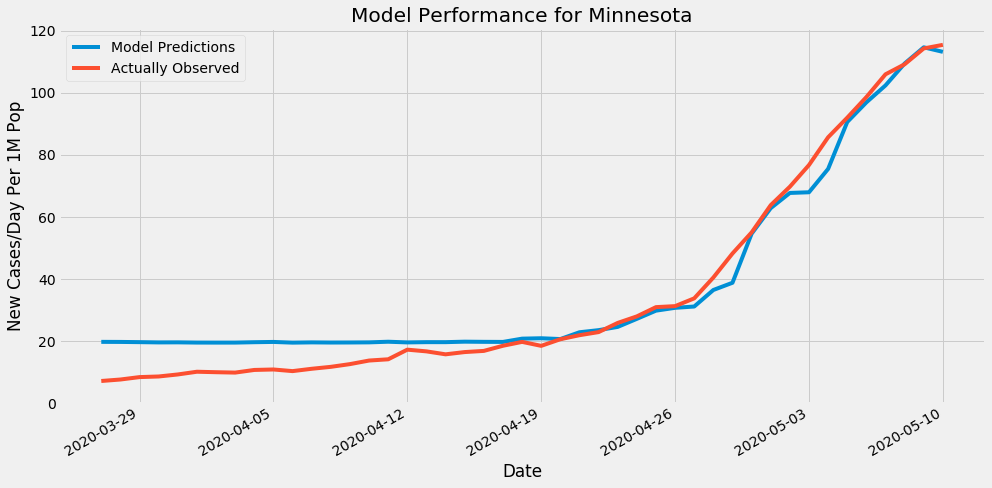

In [38]:
fig, ax = plt.subplots(figsize=(14, 7))
x = MN_ts_x['days_elapsed(t)']
ax.plot(x.apply(convert_to_date), rf_model.model.predict(MN_ts_x), label='Model Predictions')
ax.plot(x.apply(convert_to_date), MN_ts_y, label='Actually Observed')
ax.set_ylim(0)
ax.legend()
ax.set_title('Model Performance for {}'.format('Minnesota'))
ax.set_xlabel('Date')
ax.set_ylabel('New Cases/Day Per 1M Pop')
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
fig.autofmt_xdate(rotation=30)
fig.tight_layout()
fig.savefig('images/MN_perf')

In [37]:
y

[7.091896976438638,
 7.568031402418617,
 8.344882307964898,
 8.545359961009101,
 9.196912333402757,
 10.07400206547114,
 9.92364382568799,
 9.798345292535362,
 10.65037531797322,
 10.80073355775637,
 10.274479718515341,
 11.026270917431098,
 11.65276358319423,
 12.529853315262612,
 13.682599820266772,
 14.083555126355176,
 17.190958748540304,
 16.63964520266875,
 15.687376350708789,
 16.41410784299402,
 16.7900034424519,
 18.443944080066565,
 19.696929411592826,
 18.41888437343604,
 20.548959437030682,
 122.65586669666774,
 32.036886469796976,
 25.840072007383615,
 21.162388903840128,
 18.225662806293926,
 16.068620751254645,
 15.794345469863726,
 14.164942857864148,
 12.441566111706457,
 11.252003179370341,
 10.831206928232772,
 10.49704768526017,
 10.250129411491313,
 9.870275498302263,
 10.113559073009048,
 10.585129808842066,
 12.225967430580836,
 15.154378043916632,
 16.04426740753245,
 17.063322098755265,
 18.842931405377392,
 19.88793772290259]

In [43]:
x.values

array([ 41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,
        52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,
        63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,
        74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,
        85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
        96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106.])

ValueError: x and y must have same first dimension, but have shapes (66,) and (47,)

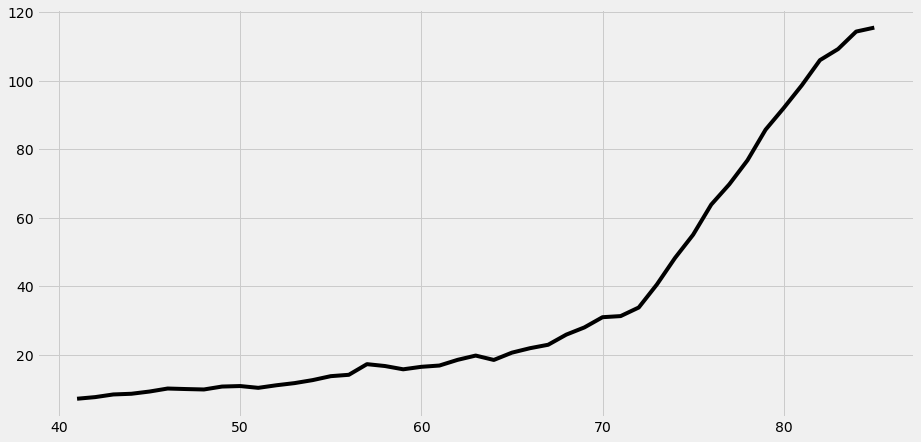

In [41]:
high_pred = generate_prediction_df(max_SD, MN_ts_x, MN_ts_y, predictions=21, rf = rf_model)
fig, ax = plt.subplots(figsize=(14, 7))
labels = ['High Social Distancing', 'Low Social Distancing']
x = high_pred[0]['days_elapsed(t)']
x.apply(lambda x: x + 88)
y = high_pred[1]

ax.plot(MN_ts_x['days_elapsed(t)'], MN_ts_y, label = 'Past Data', c = 'black')
ax.plot(x.values[, y, label= 'High Social Distancing')

low_pred = generate_prediction_df(min_SD, MN_ts_x, MN_ts_y, predictions=21, rf=rf_model)
x = low_pred[0]['days_elapsed(t)']
y = low_pred[1]
# ax.plot(x[x >= 15], y[x >= 15], label='Low Social Distancing')

ax.legend()
ax.set_title('Future Predicted Daily New Cases'.format('Minnesota'))
ax.set_xlabel('Date')
ax.set_ylabel('New Cases/Day Per 1M Pop')
# ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
# fig.autofmt_xdate(rotation=30)
fig.tight_layout()

In [39]:
x

21    41
22    42
23    43
24    44
25    45
26    46
27    47
28    48
29    49
30    50
31    51
32    52
33    53
34    54
35    55
36    56
37    57
38    58
39    59
40    60
41    61
42    62
43    63
44    64
45    65
46    66
47    67
48    68
49    69
50    70
51    71
52    72
53    73
54    74
55    75
56    76
57    77
58    78
59    79
60    80
61    81
62    82
63    83
64    84
65    85
Name: days_elapsed(t), dtype: object

In [40]:
y

[7.091896976438638,
 7.568031402418617,
 8.344882307964898,
 8.545359961009101,
 9.196912333402757,
 10.07400206547114,
 9.92364382568799,
 9.798345292535362,
 10.65037531797322,
 10.80073355775637,
 10.274479718515341,
 11.026270917431098,
 11.65276358319423,
 12.529853315262612,
 13.682599820266772,
 14.083555126355176,
 17.190958748540304,
 16.63964520266875,
 15.687376350708789,
 16.41410784299402,
 16.7900034424519,
 18.443944080066565,
 19.696929411592826,
 18.41888437343604,
 20.548959437030682,
 122.65586669666774,
 32.036886469796976,
 25.840072007383615,
 21.162388903840128,
 18.225662806293926,
 16.068620751254645,
 15.794345469863726,
 14.164942857864148,
 12.441566111706457,
 11.252003179370341,
 10.831206928232772,
 10.49704768526017,
 10.250129411491313,
 9.870275498302263,
 10.113559073009048,
 10.585129808842066,
 12.225967430580836,
 15.154378043916632,
 16.04426740753245,
 17.063322098755265,
 18.842931405377392,
 19.88793772290259]

In [104]:
convert_to_date(104)

datetime.date(2020, 5, 29)

In [ ]:
covid_df = load_and_clean_data()

In [26]:
covid_df = load_and_clean_data()
Similar_States_Init = Comparable_S

fig, ax = plt.subplots(figsize = (14, 7))
feat_importance = pd.DataFrame(State_Compile.get_feature_importances().T.iloc[:, -9:].values.flatten()).T
cols = State_Compile.get_feature_importances().T.iloc[:, -9:].columns.values
feat_importance.columns = [x.replace('_', ' ').replace('(t)', '').title() for x in cols]
feat_importance.sort_values(by =0, axis = 1, ascending = False, inplace = True)
colors = ['blue', 'grey', 'blue', 'blue', 'blue', 'blue', 'gray', 'grey', 'blue']

ax.bar(feat_importance.columns, feat_importance.values.flatten(), color = colors)
plt.yscale('log')
ax.set_title('Feature Importances for {}'.format(state))
ax.set_ylabel('Feature Importance')
fig.autofmt_xdate(rotation = 20)
fig.tight_layout()
fig.savefig('images/MN_Feat')

,state,days_since_start,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,driving,pop_density,New_Cases_per_pop
3829,Vermont,-14,1.10,1.00,1.28,1.25,1.02,0.99,1.4859,68.141586,0.000000
3830,Vermont,-13,1.13,1.11,1.49,1.13,1.04,0.98,1.2617,68.141586,0.000000
3831,Vermont,-12,1.09,1.09,1.52,1.08,0.99,1.00,1.0102,68.141586,0.000000
3832,Vermont,-11,1.01,1.03,1.02,1.03,0.99,1.01,0.9711,68.141586,0.000000
3833,Vermont,-10,1.03,1.05,0.96,1.02,0.99,1.01,0.9578,68.141586,1.592202
...,...,...,...,...,...,...,...,...,...,...,...
3908,Vermont,65,0.77,0.88,2.62,0.50,0.26,1.19,0.9709,68.141586,5.004064
3909,Vermont,66,0.84,0.97,2.30,0.72,0.58,1.13,1.0707,68.141586,5.231521
3910,Vermont,67,0.84,0.97,2.25,0.73,0.59,1.14,1.1016,68.141586,6.141351
3911,Vermont,68,0.80,0.93,1.79,0.74,0.61,1.14,1.0433,68.141586,5.458978


In [18]:
Prediction_Insights.similar_df[:50]

,New_Cases_per_pop(t-21),New_Cases_per_pop(t-20),New_Cases_per_pop(t-19),New_Cases_per_pop(t-18),New_Cases_per_pop(t-17),New_Cases_per_pop(t-16),New_Cases_per_pop(t-15),New_Cases_per_pop(t-14),New_Cases_per_pop(t-13),New_Cases_per_pop(t-12),...,days_elapsed(t),retail_and_recreation(t),grocery_and_pharmacy(t),parks(t),transit_stations(t),workplaces(t),residential(t),driving(t),pop_density(t),New_Cases_per_pop(t)
21,0,1.02643,0,0,0.684284,0.855355,0.782039,1.14862,1.71071,2.32168,...,1,0.5,0.76,1.04,0.43,0.47,1.22,0.4499,56.4011,28.2023
22,1.02643,0,0,0.684284,0.855355,0.782039,1.14862,1.71071,2.32168,3.12816,...,2,0.47,0.74,0.58,0.4,0.47,1.25,0.472,56.4011,33.5055
23,0,0,0.684284,0.855355,0.782039,1.14862,1.71071,2.32168,3.12816,3.64137,...,3,0.44,0.72,0.61,0.41,0.6,1.17,0.4294,56.4011,38.7598
24,0,0.684284,0.855355,0.782039,1.14862,1.71071,2.32168,3.12816,3.64137,4.05683,...,4,0.49,0.73,0.88,0.4,0.6,1.13,0.3675,56.4011,42.1323
25,0.684284,0.855355,0.782039,1.14862,1.71071,2.32168,3.12816,3.64137,4.05683,4.44785,...,5,0.56,0.77,1,0.44,0.5,1.19,0.4652,56.4011,46.6046
26,0.855355,0.782039,1.14862,1.71071,2.32168,3.12816,3.64137,4.05683,4.44785,5.59647,...,6,0.6,0.83,1.23,0.48,0.47,1.2,0.5046,56.4011,50.7836
27,0.782039,1.14862,1.71071,2.32168,3.12816,3.64137,4.05683,4.44785,5.59647,6.98947,...,7,0.59,0.83,1.16,0.46,0.46,1.21,0.5038,56.4011,55.2315
28,1.14862,1.71071,2.32168,3.12816,3.64137,4.05683,4.44785,5.59647,6.98947,9.0912,...,8,0.52,0.77,0.54,0.37,0.44,1.24,0.4442,56.4011,56.1113
29,1.71071,2.32168,3.12816,3.64137,4.05683,4.44785,5.59647,6.98947,9.0912,11.1196,...,9,0.53,0.8,0.63,0.4,0.46,1.25,0.5054,56.4011,59.8015
30,2.32168,3.12816,3.64137,4.05683,4.44785,5.59647,6.98947,9.0912,11.1196,13.6857,...,10,0.5,0.79,0.79,0.43,0.6,1.16,0.4883,56.4011,61.4145


100

In [106]:
104-15

89

In [9]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({'font.size': 18})
plt.style.use('fivethirtyeight')
plt.close('all')


In [10]:
State_Compile.get_feature_importances().T

,Daily New Cases(t-21),Daily New Cases(t-20),Daily New Cases(t-19),Daily New Cases(t-18),Daily New Cases(t-17),Daily New Cases(t-16),Daily New Cases(t-15),Daily New Cases(t-14),Daily New Cases(t-13),Daily New Cases(t-12),...,Daily New Cases(t-1),days_elapsed(t),retail_and_recreation(t),grocery_and_pharmacy(t),parks(t),transit_stations(t),workplaces(t),residential(t),driving(t),pop_density(t)
0,0.001636,0.002874,0.006829,0.004953,0.003924,0.01168,0.001763,0.006299,0.004997,0.006804,...,0.096367,0.001186,0.003624,0.001906,0.201142,0.002225,0.007343,0.020798,0.003327,0.056667


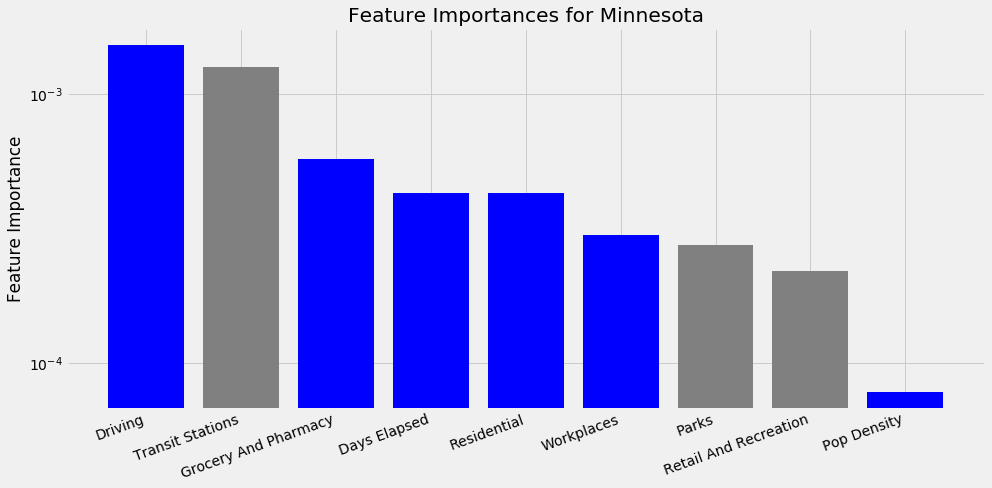

In [46]:
fig, ax = plt.subplots(figsize = (14, 7))
feat_importance = pd.DataFrame(State_Compile.get_feature_importances().T.iloc[:, -9:].values.flatten()).T
cols = State_Compile.get_feature_importances().T.iloc[:, -9:].columns.values
feat_importance.columns = [x.replace('_', ' ').replace('(t)', '').title() for x in cols]
feat_importance.sort_values(by =0, axis = 1, ascending = False, inplace = True)
colors = ['blue', 'grey', 'blue', 'blue', 'blue', 'blue', 'gray', 'grey', 'blue']

ax.bar(feat_importance.columns, feat_importance.values.flatten(), color = colors)
plt.yscale('log')
ax.set_title('Feature Importances for {}'.format(state))
ax.set_ylabel('Feature Importance')
fig.autofmt_xdate(rotation = 20)
fig.tight_layout()
fig.savefig('images/MN_Feat')

In [12]:
Recov_df = round(Similar_States_Init.master_pop_density_df.loc[np.append(similar_states, state)], 1)
Recov_df.rename(columns = {'pop_density': 'People/Square Mile'}, inplace = True)
Recov_df.index.name = 'State'

In [13]:
Recov_df

,People/Square Mile,Recovery Factor
State,,
Colorado,56.4,2.0
Iowa,56.9,1.6
Oklahoma,57.7,1.4
Vermont,68.1,12.1
Missouri,89.7,1.6
Minnesota,71.6,1.0


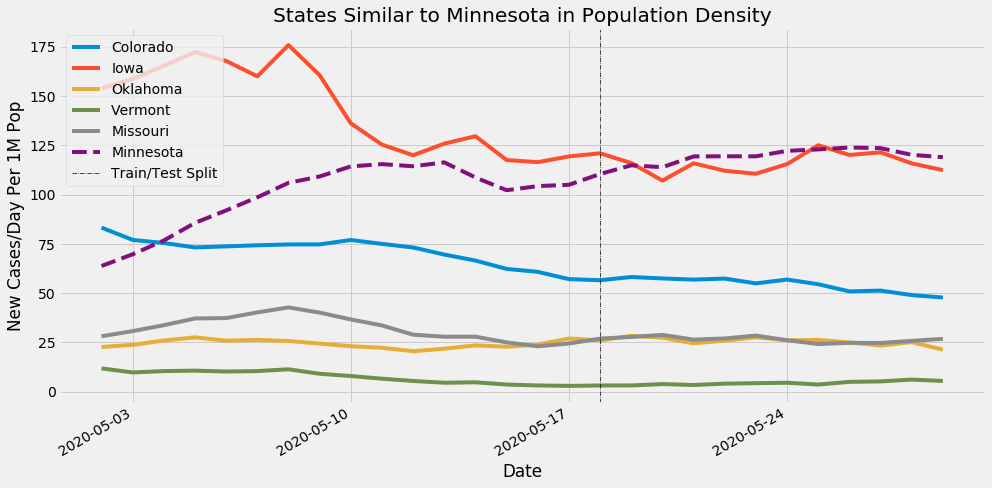

In [14]:
Prediction_Insights.plot_similar_states(save = 'images/SimilarTo{}'.format(state))

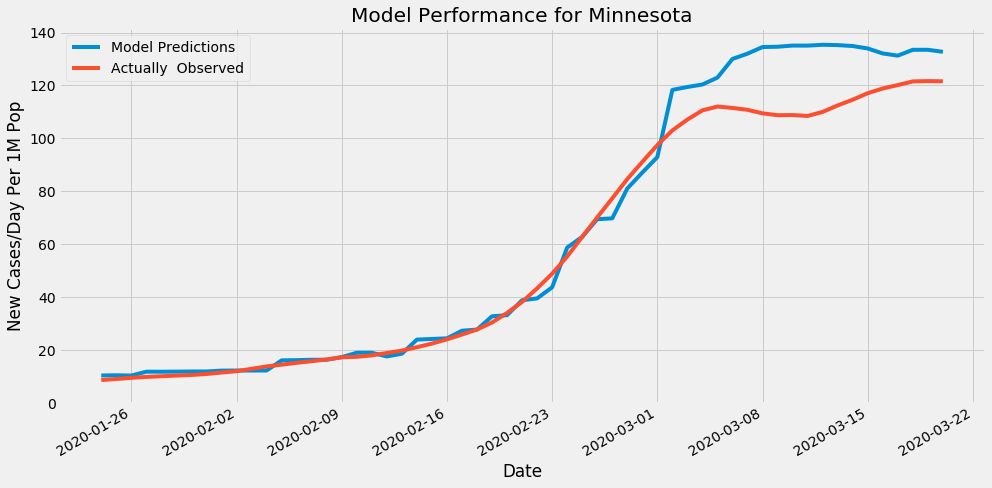

In [52]:
Prediction_Insights.plot_pred_vs_actual(save = 'images/ModelPerf{}'.format(state))

In [53]:
Prediction_Insights.forecast_to_future(save = 'images/forecast2for{}'.format(state))

KeyError: 'Daily New Cases(t-1)'

In [42]:
SD_Table = Prediction_Insights.get_social_distancing_estimates(analysis = True)

In [43]:
round(SD_Table, 1)

,Retail/Recreation %,Grocery/Pharmacy %,Parks %,Transit Stations %,Workplaces %,Residential %,Driving %
,,,,,,,
High,52.7,74.0,94.1,43.3,50.1,119.4,55.8
Low,93.9,117.0,229.9,96.1,72.7,108.6,124.7


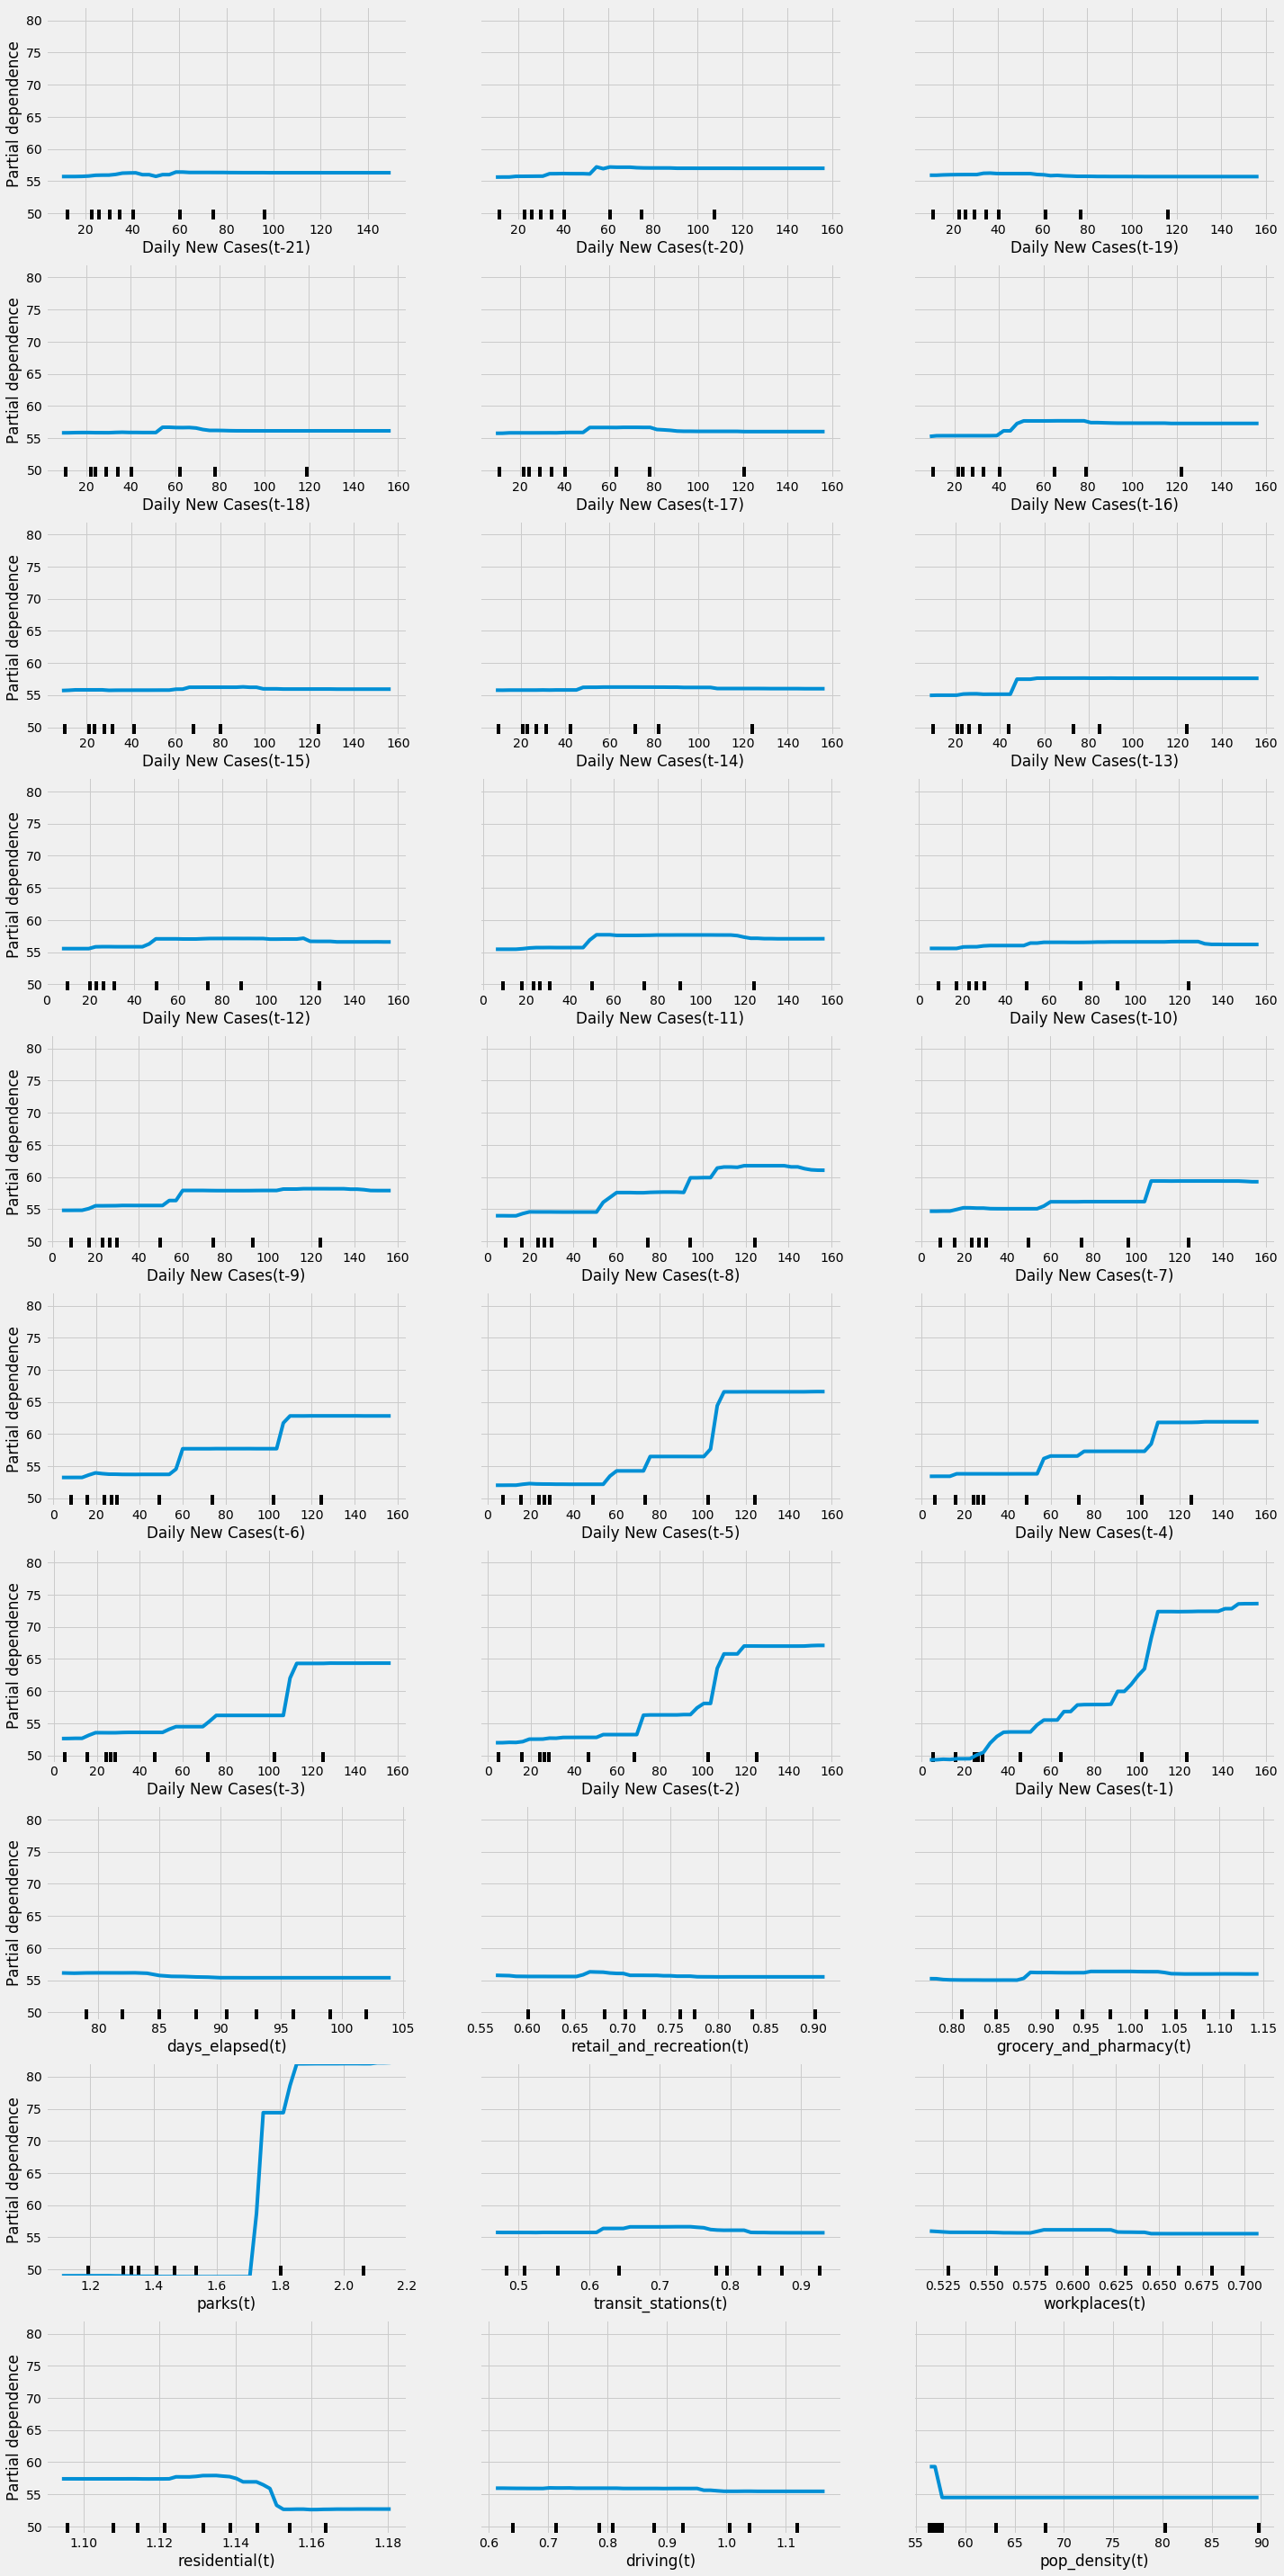

In [59]:
from sklearn.inspection import plot_partial_dependence
plot_partial_dependence(State_Compile.rf.model, State_Compile.X, State_Compile.X.columns, grid_resolution = 50)
fig = plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(40)
fig.tight_layout()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a5278a898>,
      dtype=object)

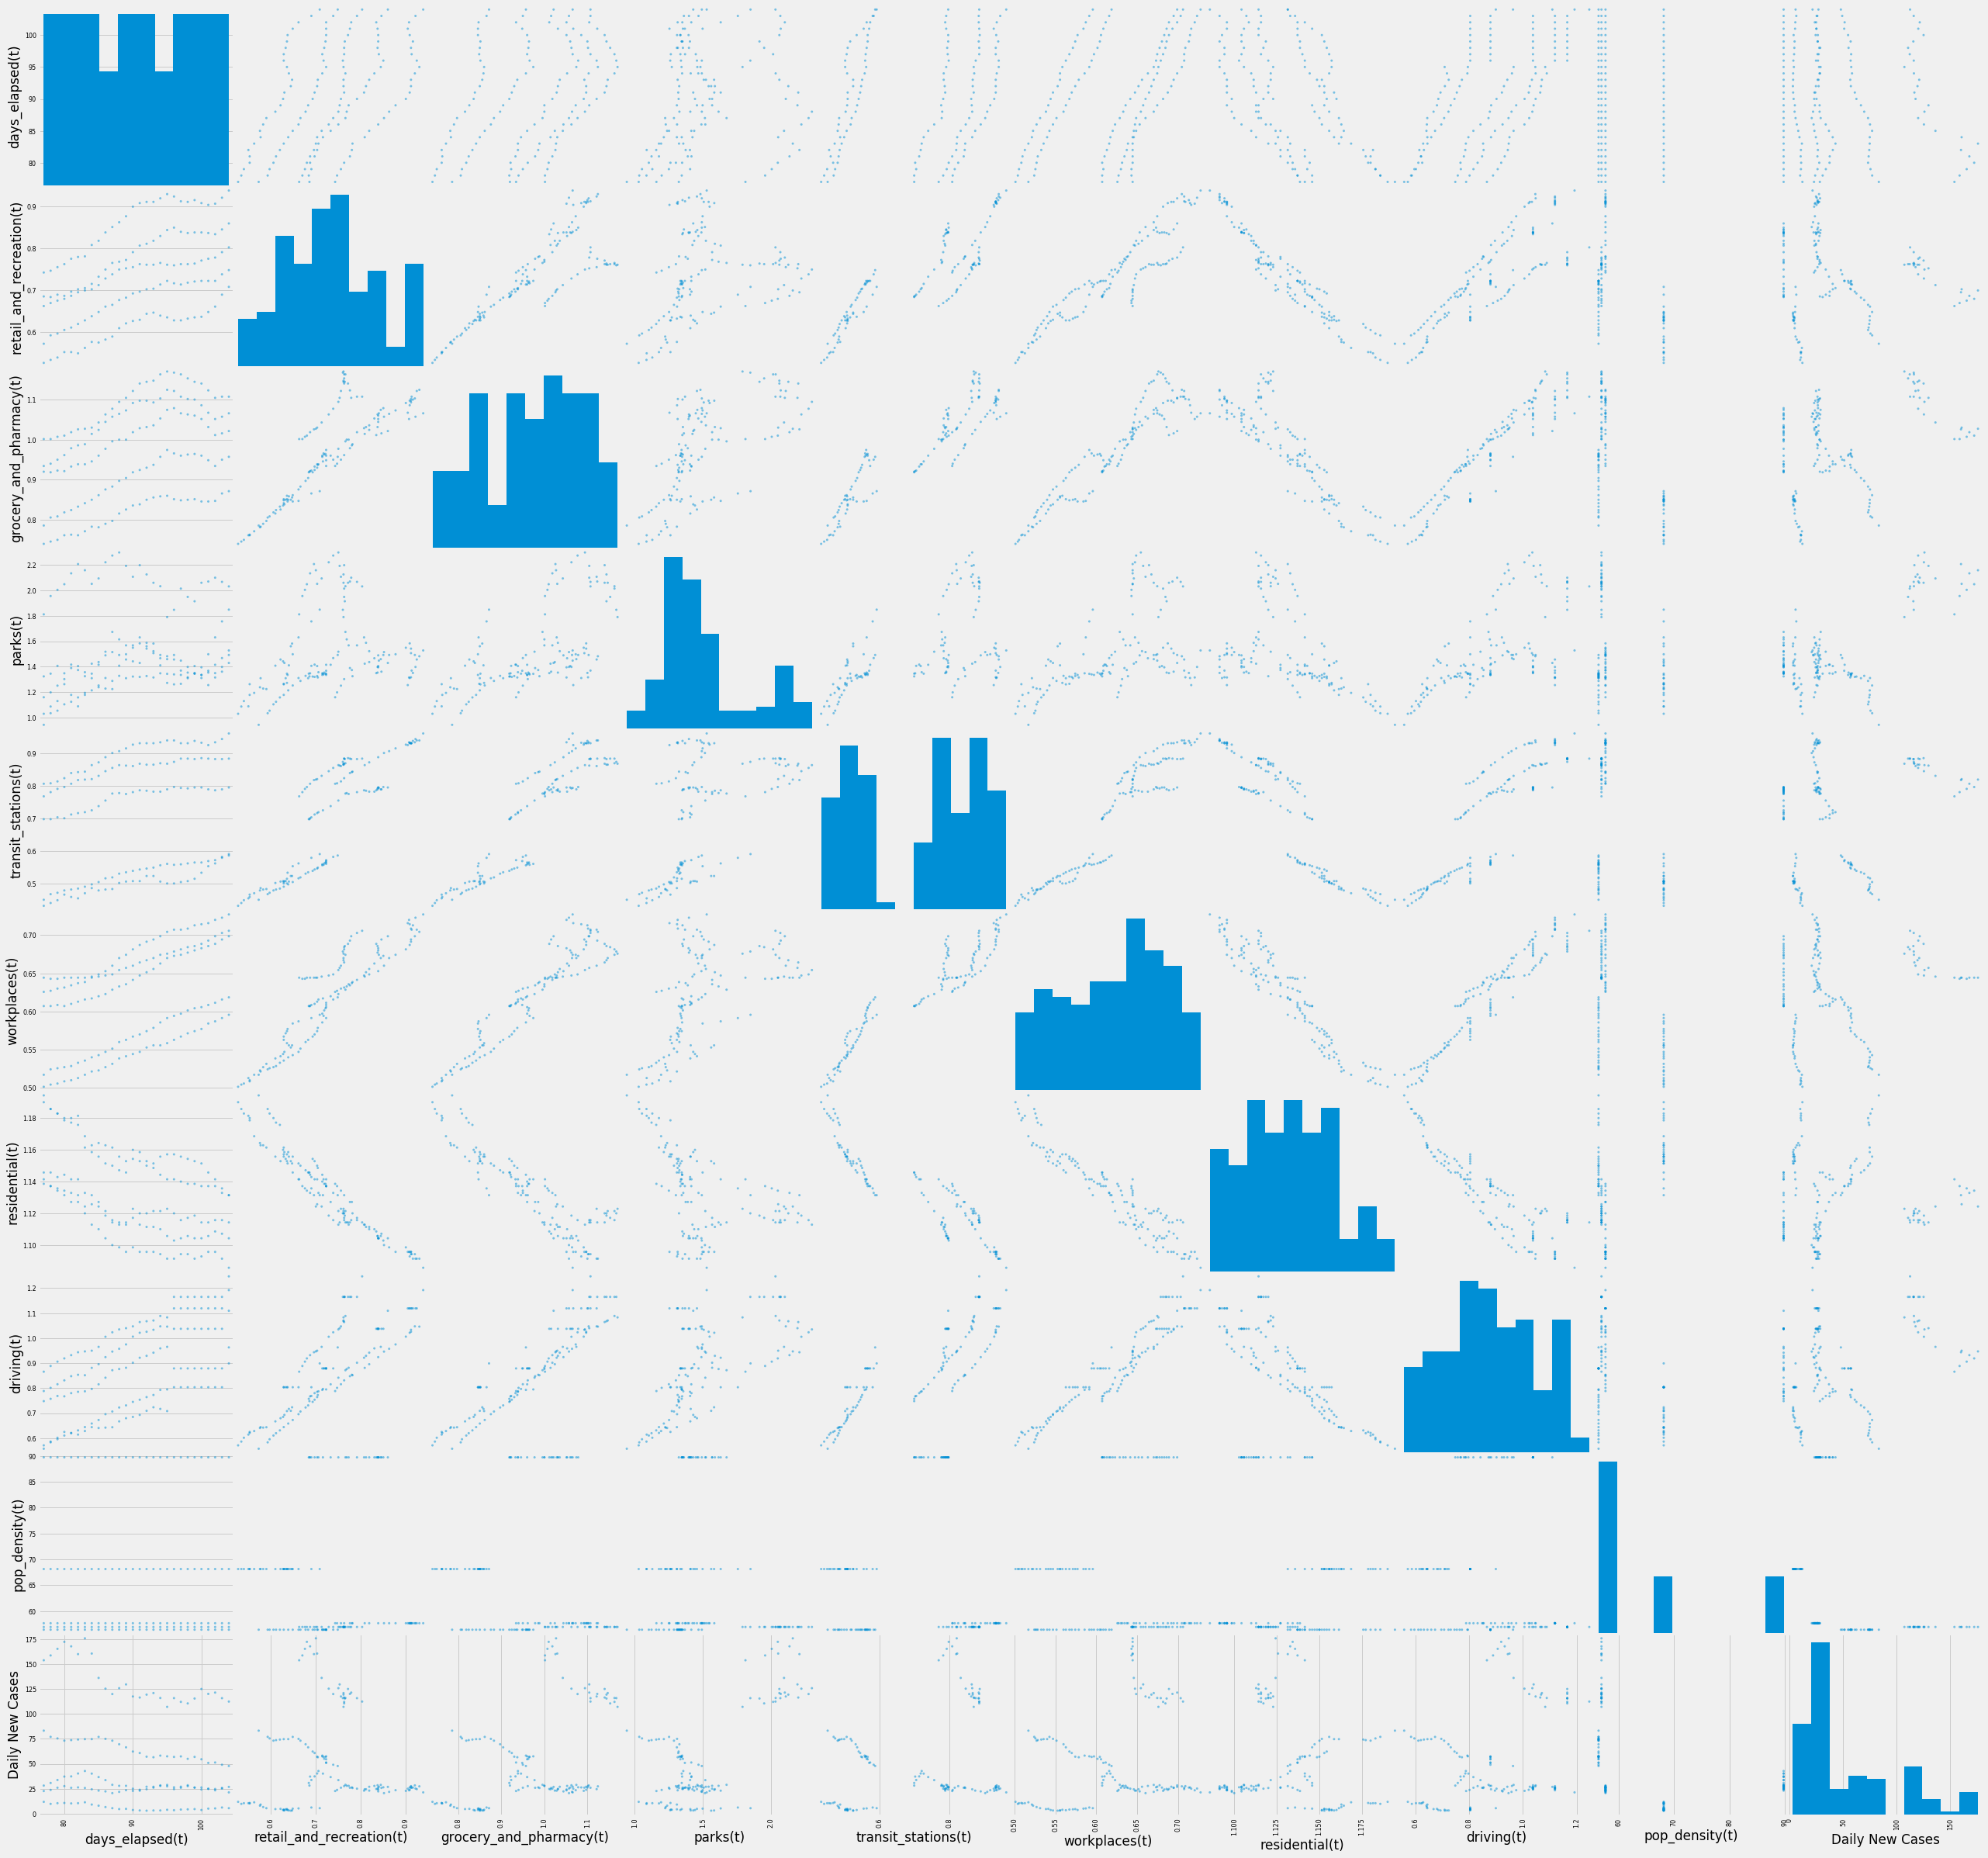

In [633]:
## from pandas.plotting import scatter_matrix
total = State_Compile.X.iloc[:,-9:].copy()
total['Daily New Cases'] = State_Compile.y
scatter_matrix(total, figsize = (40,40))

Text(0.5, 0.98, 'MN Social Distancing Features')

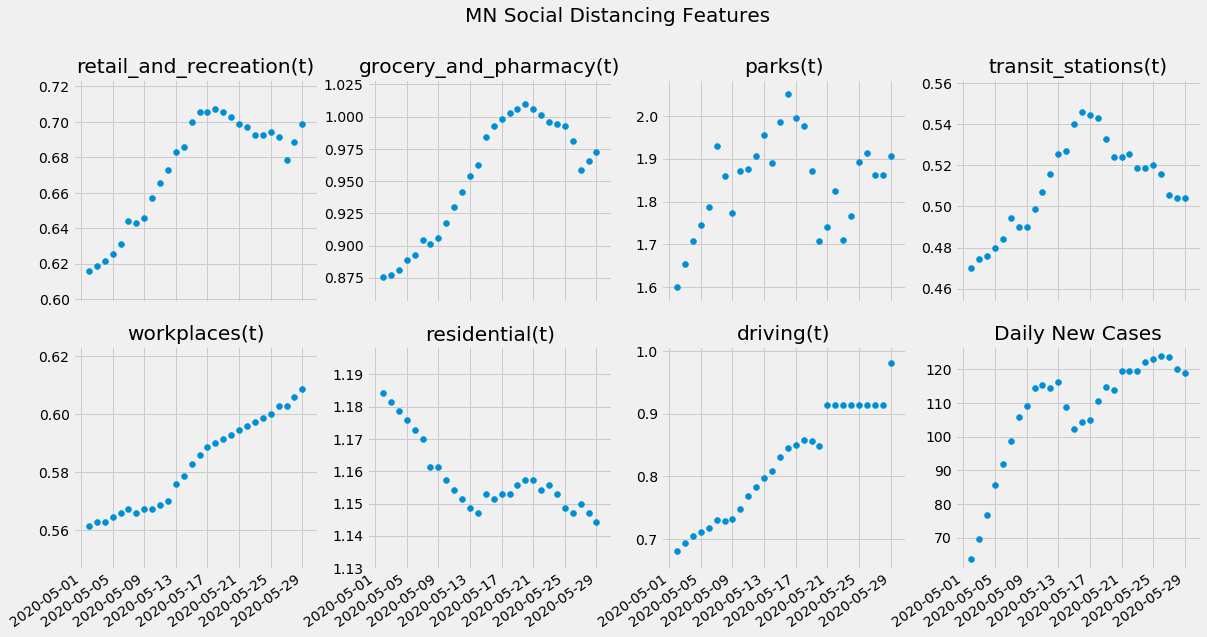

In [109]:
SD_time = Prediction_Insights.State_Analysis_X.iloc[:, -9:-1]
x = SD_time['days_elapsed(t)']
fig, axes = plt.subplots(2, 4, figsize = (18, 10))
for i, ax in enumerate(axes.flatten(), 1):
    try:
        ax.scatter(x.apply(convert_to_date), SD_time.iloc[:,i])
        ax.set_title(SD_time.columns[i])
    except:
        ax.scatter(x.apply(convert_to_date), Prediction_Insights.State_Analysis_y)
        ax.set_title('Daily New Cases')
    ax.set_xlim(convert_to_date(75), convert_to_date(106))
    
fig.autofmt_xdate(rotation = 35)
fig.suptitle("MN Social Distancing Features", fontsize=20)

In [110]:
fig.savefig('images/MN_SocialD')

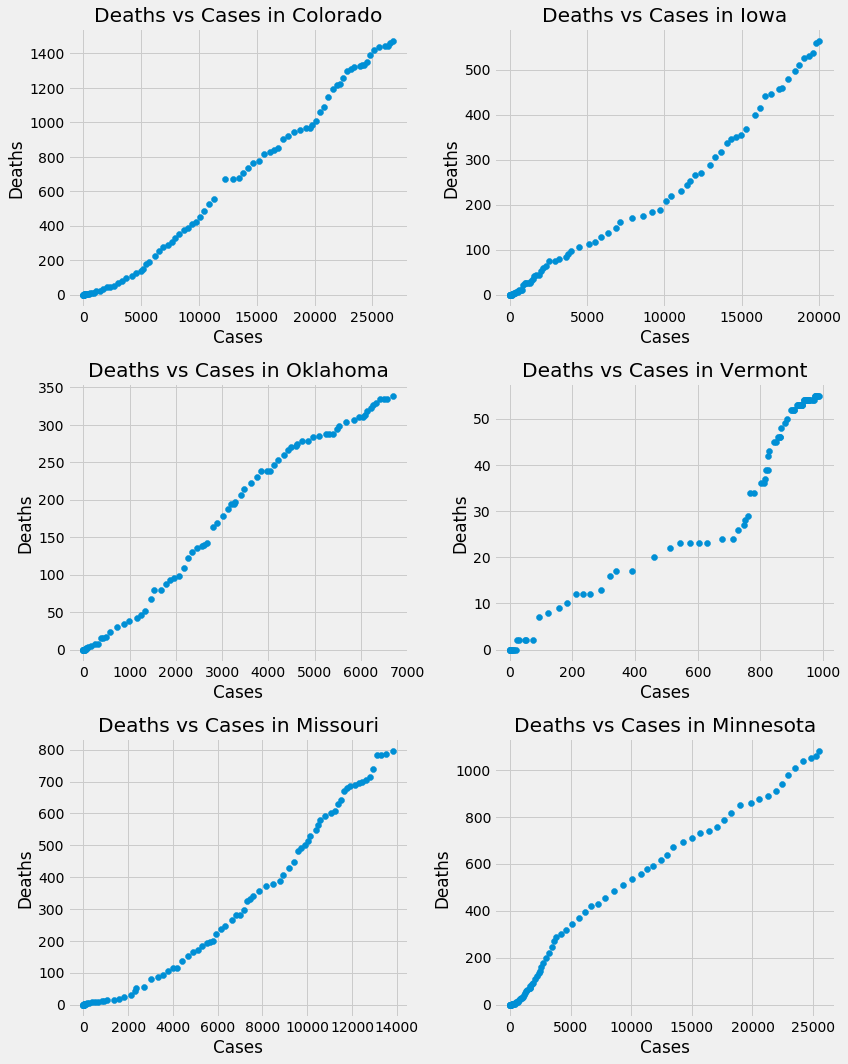

In [653]:
# Plot state deaths vs cases
def raw_state_data(states):
    covid_raw_df = pd.read_csv('data/covid-19-data/us-states.csv')
    state_raw_list = []
    for state in states:
        state_raw_list.append(covid_raw_df[covid_raw_df['state'] == state])
    return state_raw_list

fig, axes = plt.subplots(3, 2, figsize = (12,15))
similar_states = np.append(similar_states, 'Minnesota')
state_list = raw_state_data(similar_states)

for i, ax in enumerate(axes.flatten()):
    try:
        state_name = state_list[i]['state'].unique()[0]
        ax.scatter(state_list[i]['cases'], state_list[i]['deaths'])
        ax.set_title('Deaths vs Cases in {}'.format(state_name))
        ax.set_xlabel('Cases')
        ax.set_ylabel('Deaths')
    except:
        continue
fig.tight_layout()
# Mostly linear trend between cases and deaths
fig.savefig('images/DeathVsCases')

In [8]:
state = 'Colorado'

covid_df = load_and_clean_data()
Similar_States_Init = Comparable_States()
Similar_States_Init.make_master_pop_dens_df()
sim_states_df = Similar_States_Init.get_similar_states(
    state_to_predict=state, recovery_factor_min= 2, pop_density_tolerance=25)
similar_states = sim_states_df.index.values
State_Compile = Combined_State_Analysis(similar_states, print_err=True)
State_Compile.get_feature_importances().T
print("The Most similar states to {} that meet the comparable parameters are: {}. These will be used to predict for {}.".format(
    state, similar_states, state))

Prediction_Insights = Predictions(covid_df, state, similar_states, State_Compile)

rmse: 6.811271993116912
The Most similar states to Colorado that meet the comparable parameters are: ['Kansas' 'Oregon' 'Colorado' 'Vermont']. These will be used to predict for Colorado.


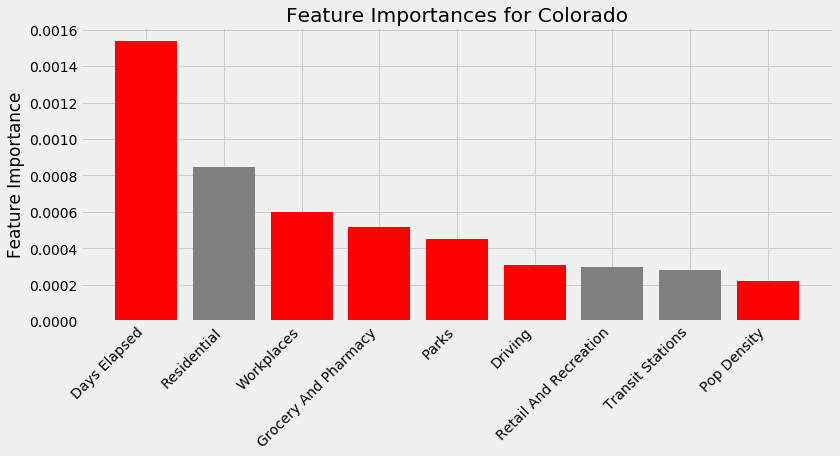

In [15]:
fig, ax = plt.subplots(figsize = (12, 6))
feat_importance = pd.DataFrame(State_Compile.get_feature_importances().T.iloc[:, -9:].values.flatten()).T
cols = State_Compile.get_feature_importances().T.iloc[:, -9:].columns.values
feat_importance.columns = [x.replace('_', ' ').replace('(t)', '').title() for x in cols]
feat_importance.sort_values(by =0, axis = 1, ascending = False, inplace = True)
colors = ['red', 'grey', 'red', 'red', 'red', 'red', 'grey', 'grey']

ax.bar(feat_importance.columns, feat_importance.values.flatten(), color = colors)
ax.set_title('Feature Importances for {}'.format(state))
ax.set_ylabel('Feature Importance')
fig.autofmt_xdate(rotation = 45)
fig.savefig('images/MN_Feat')

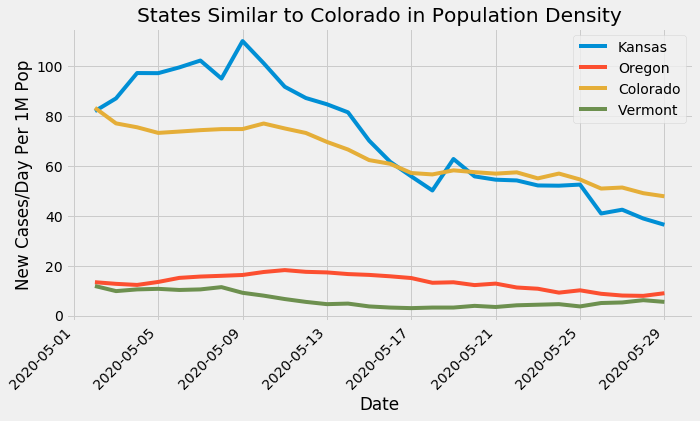

In [10]:
import matplotlib.pyplot as plt
Prediction_Insights.plot_similar_states(save = 'images/SimilarTo{}'.format(state))

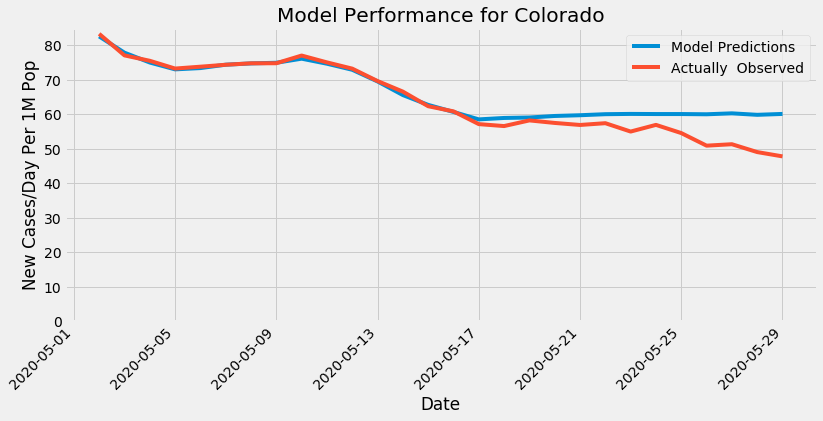

In [11]:
Prediction_Insights.plot_pred_vs_actual(save = 'images/ModelPerf{}'.format(state))

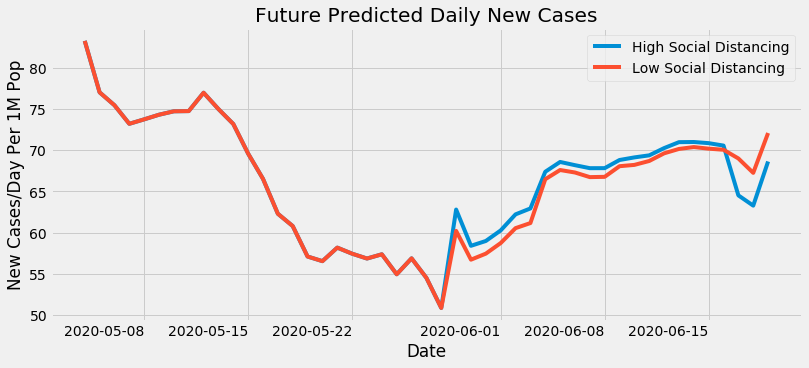

In [12]:
Prediction_Insights.forecast_to_future(save = 'images/forecastfor{}'.format(state))

In [13]:
SD_Table = Prediction_Insights.get_social_distancing_estimates(analysis = True)

In [14]:
SD_Table

,Retail/Recreation %,Grocery/Pharmacy %,Parks %,Transit Stations %,Workplaces %,Residential %,Driving %
,,,,,,,
Low,52.71,74.00,94.14,43.29,50.14,119.43,55.75
High,83.57,103.57,217.71,93.43,70.14,110.00,117.09


In [57]:
state = 'California'

covid_df = load_and_clean_data()
Similar_States_Init = Comparable_States()
Similar_States_Init.make_master_pop_dens_df()
sim_states_df = Similar_States_Init.get_similar_states(
    state_to_predict=state, recovery_factor_min= 1.5, pop_density_tolerance= 100)
similar_states = sim_states_df.index.values
State_Compile = Combined_State_Analysis(similar_states, print_err=True)
State_Compile.get_feature_importances().T
print("The Most similar states to {} that meet the comparable parameters are: {}. These will be used to predict for {}.".format(
    state, similar_states, state))

Prediction_Insights = Predictions(covid_df, state, similar_states, State_Compile)

rmse: 7.313866980494069
The Most similar states to California that meet the comparable parameters are: ['Michigan' 'Indiana' 'Hawaii' 'Pennsylvania' 'Ohio']. These will be used to predict for California.


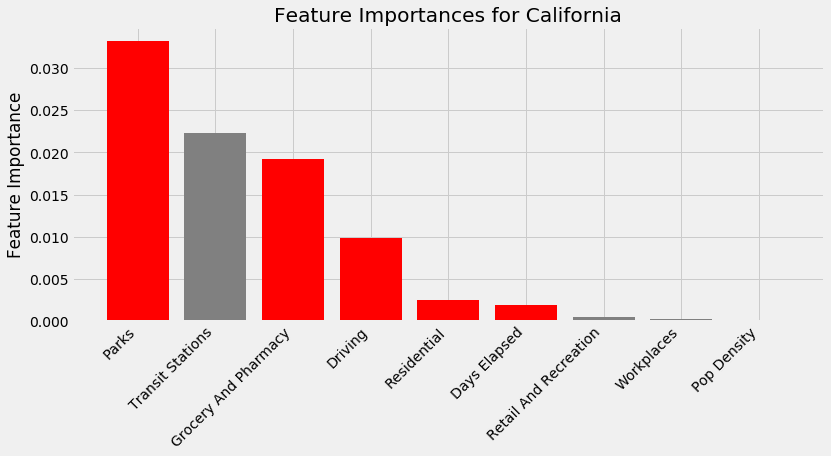

In [58]:
fig, ax = plt.subplots(figsize = (12, 6))
feat_importance = pd.DataFrame(State_Compile.get_feature_importances().T.iloc[:, -9:].values.flatten()).T
cols = State_Compile.get_feature_importances().T.iloc[:, -9:].columns.values
feat_importance.columns = [x.replace('_', ' ').replace('(t)', '').title() for x in cols]
feat_importance.sort_values(by =0, axis = 1, ascending = False, inplace = True)
colors = ['red', 'grey', 'red', 'red', 'red', 'red', 'grey', 'grey']

ax.bar(feat_importance.columns, feat_importance.values.flatten(), color = colors)
ax.set_title('Feature Importances for {}'.format(state))
ax.set_ylabel('Feature Importance')
fig.autofmt_xdate(rotation = 45)
# fig.savefig('images/MN_Feat')

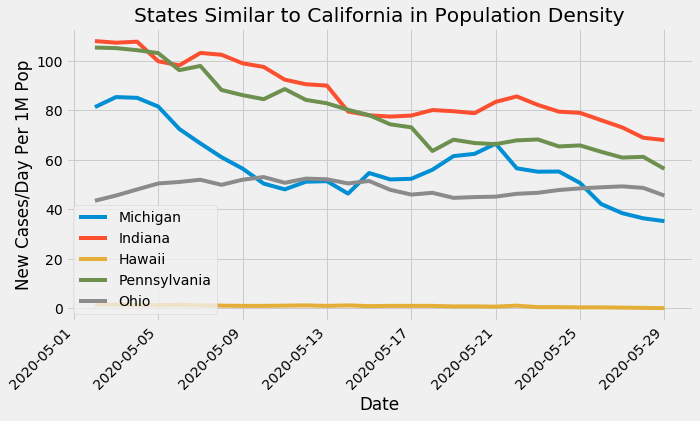

In [59]:
import matplotlib.pyplot as plt
Prediction_Insights.plot_similar_states(save = 'images/SimilarTo{}'.format(state))

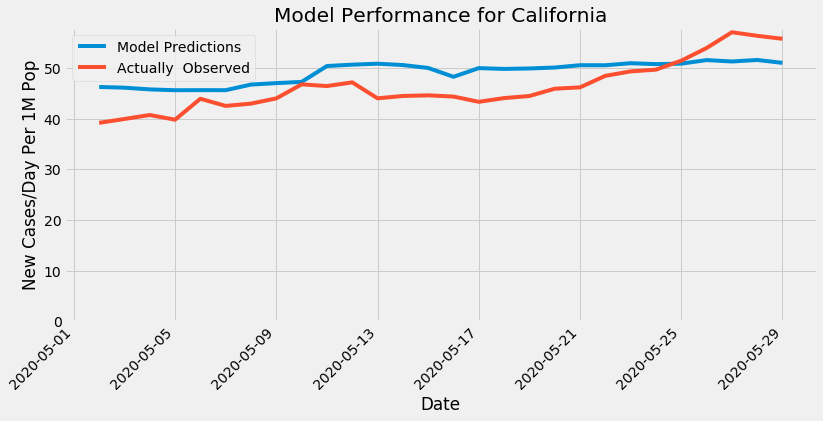

In [60]:
Prediction_Insights.plot_pred_vs_actual(save = 'images/ModelPerf{}'.format(state))

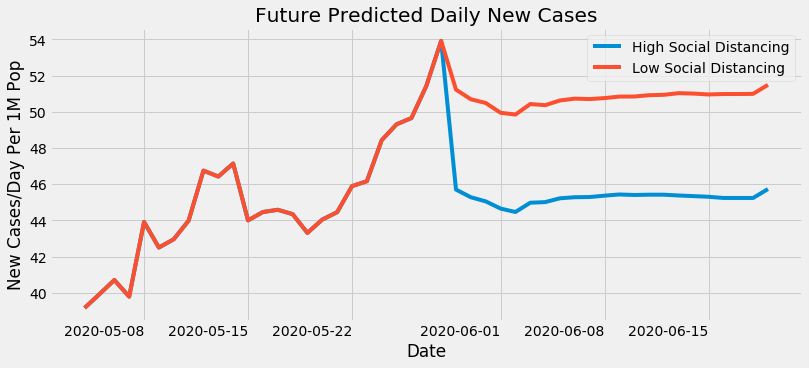

In [61]:
Prediction_Insights.forecast_to_future(save = 'images/forecastfor{}'.format(state))

In [62]:
SD_Table = Prediction_Insights.get_social_distancing_estimates(analysis = True)

In [63]:
SD_Table

,Retail/Recreation %,Grocery/Pharmacy %,Parks %,Transit Stations %,Workplaces %,Residential %,Driving %
,,,,,,,
High,47.29,69.86,36.14,30.43,46.00,121.86,32.89
Low,85.29,103.71,211.00,88.29,68.57,111.57,116.06


In [182]:
state = 'Texas'

covid_df = load_and_clean_data()
Similar_States_Init = Comparable_States()
Similar_States_Init.make_master_pop_dens_df()
sim_states_df = Similar_States_Init.get_similar_states(
    state_to_predict=state, recovery_factor_min= 1.0, pop_density_tolerance= 10)
similar_states = sim_states_df.index.values
State_Compile = Combined_State_Analysis(similar_states, print_err=True)
State_Compile.get_feature_importances().T
print("The Most similar states to {} that meet the comparable parameters are: {}. These will be used to predict for {}.".format(
    state, similar_states, state))

Prediction_Insights = Predictions(covid_df, state, similar_states, State_Compile)

rmse: 9.89940331291399
The Most similar states to Texas that meet the comparable parameters are: ['Louisiana' 'Texas' 'Kentucky' 'Washington']. These will be used to predict for Texas.


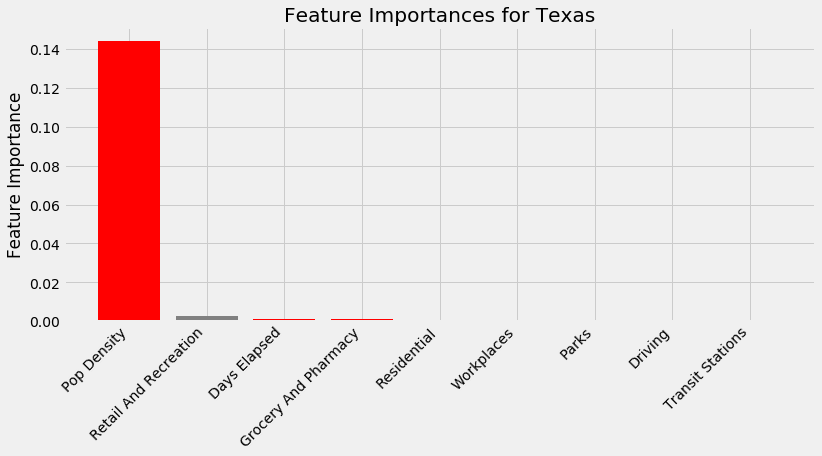

In [183]:
fig, ax = plt.subplots(figsize = (12, 6))
feat_importance = pd.DataFrame(State_Compile.get_feature_importances().T.iloc[:, -9:].values.flatten()).T
cols = State_Compile.get_feature_importances().T.iloc[:, -9:].columns.values
feat_importance.columns = [x.replace('_', ' ').replace('(t)', '').title() for x in cols]
feat_importance.sort_values(by =0, axis = 1, ascending = False, inplace = True)
colors = ['red', 'grey', 'red', 'red', 'red', 'red', 'grey', 'grey']

ax.bar(feat_importance.columns, feat_importance.values.flatten(), color = colors)
ax.set_title('Feature Importances for {}'.format(state))
ax.set_ylabel('Feature Importance')
fig.autofmt_xdate(rotation = 45)
# fig.savefig('images/MN_Feat')

In [15]:
for each in enumerate(np.array(['saf','fdasfa'])):
    print(each)

(0, 'saf')
(1, 'fdasfa')


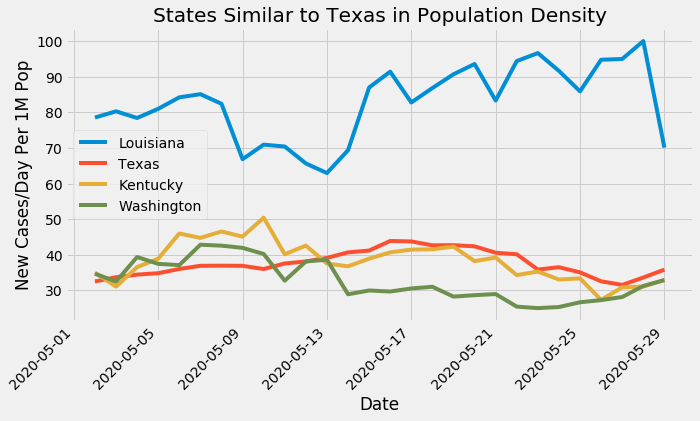

In [184]:
import matplotlib.pyplot as plt
Prediction_Insights.plot_similar_states(save = 'images/SimilarTo{}'.format(state))

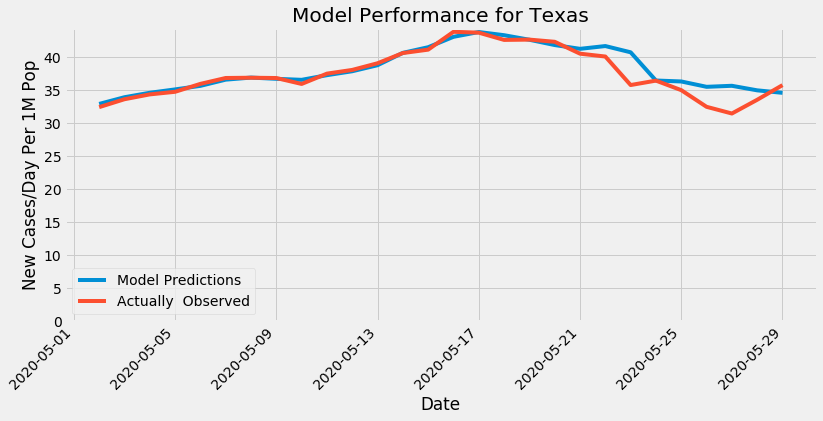

In [185]:
Prediction_Insights.plot_pred_vs_actual(save = 'images/ModelPerf{}'.format(state))

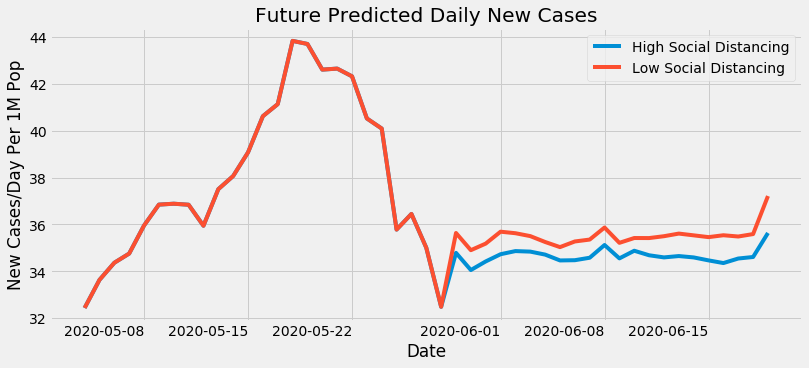

In [186]:
Prediction_Insights.forecast_to_future(save = 'images/forecastfor{}'.format(state))

In [187]:
SD_Table = Prediction_Insights.get_social_distancing_estimates(analysis = True)

In [188]:
SD_Table

,Retail/Recreation %,Grocery/Pharmacy %,Parks %,Transit Stations %,Workplaces %,Residential %,Driving %
,,,,,,,
High,60.86,84.29,76.00,47.29,50.57,118.14,58.23
Low,79.43,106.71,172.43,81.14,70.00,111.14,114.89


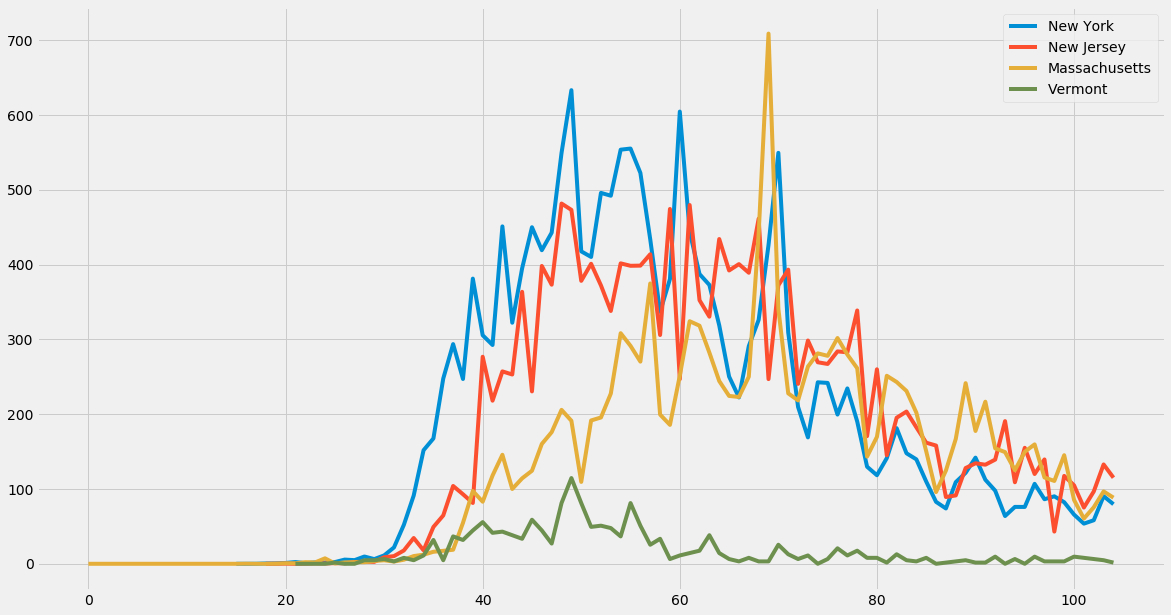

In [611]:
def plot_state(st, type = 'line', label = None):
    st_df = covid_df[covid_df['state'] == st]
    if type == 'line':
        plt.plot(st_df['days_elapsed'], st_df['New_Cases_per_pop'], label = label)
    else:
        plt.scatter(st_df['days_elapsed'], st_df['New_Cases_per_pop'], label = label)
    st_df = st_df.drop(['state', 'pop_density'], axis = 1)
    st_df.index.name = st
    return st_df

fig, axes = plt.subplots(figsize = (18, 10))
plt_type = 'line'
NY_df = plot_state('New York', type = plt_type, label = 'New York')
NJ_df = plot_state('New Jersey', type = plt_type, label = 'New Jersey')
MA_df = plot_state('Massachusetts', type = plt_type, label = 'Massachusetts')
VM_df = plot_state('Vermont', type = plt_type, label = 'Vermont')
plt.legend()

In [140]:
state = 'Wisconsin'

covid_df = load_and_clean_data()
Similar_States_Init = Comparable_States()
Similar_States_Init.make_master_pop_dens_df()
sim_states_df = Similar_States_Init.get_similar_states(
    state_to_predict=state, recovery_factor_min= 1, pop_density_tolerance=60)
similar_states = sim_states_df.index.values
State_Compile = Combined_State_Analysis(similar_states, print_err=True)
State_Compile.get_feature_importances().T
print("The Most similar states to {} that meet the comparable parameters are: {}. These will be used to predict for {}.".format(
    state, similar_states, state))

Prediction_Insights = Predictions(covid_df, state, similar_states, State_Compile)

rmse: 5.6658043242474125
The Most similar states to Wisconsin that meet the comparable parameters are: ['Colorado' 'Iowa' 'Oklahoma' 'Arkansas' 'Arizona' 'Vermont' 'Minnesota'
 'West Virginia' 'Missouri' 'Alabama' 'Louisiana' 'Texas' 'Kentucky'
 'Washington' 'New Hampshire' 'Tennessee']. These will be used to predict for Wisconsin.


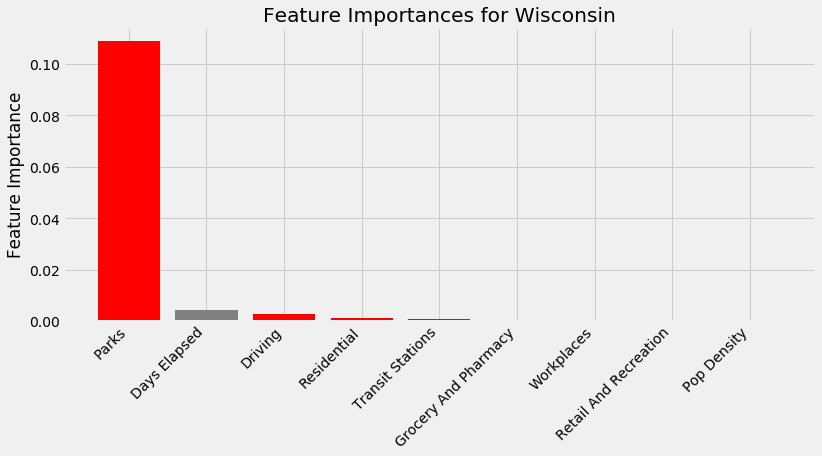

In [141]:
fig, ax = plt.subplots(figsize = (12, 6))
feat_importance = pd.DataFrame(State_Compile.get_feature_importances().T.iloc[:, -9:].values.flatten()).T
cols = State_Compile.get_feature_importances().T.iloc[:, -9:].columns.values
feat_importance.columns = [x.replace('_', ' ').replace('(t)', '').title() for x in cols]
feat_importance.sort_values(by =0, axis = 1, ascending = False, inplace = True)
colors = ['red', 'grey', 'red', 'red', 'red', 'red', 'grey', 'grey']

ax.bar(feat_importance.columns, feat_importance.values.flatten(), color = colors)
ax.set_title('Feature Importances for {}'.format(state))
ax.set_ylabel('Feature Importance')
fig.autofmt_xdate(rotation = 45)
# fig.savefig('images/MN_Feat')

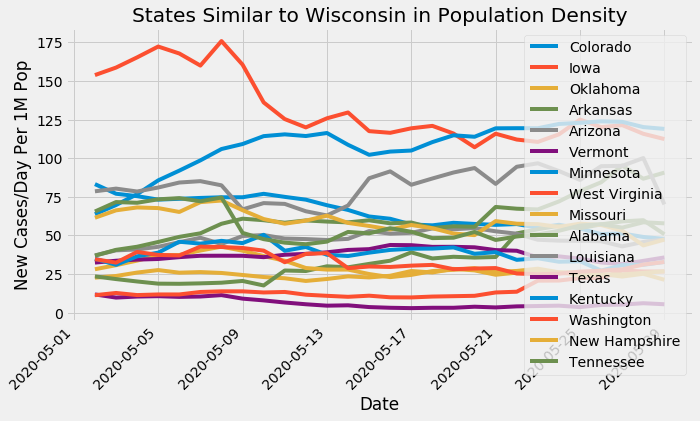

In [142]:
import matplotlib.pyplot as plt
Prediction_Insights.plot_similar_states(save = 'images/SimilarTo{}'.format(state))

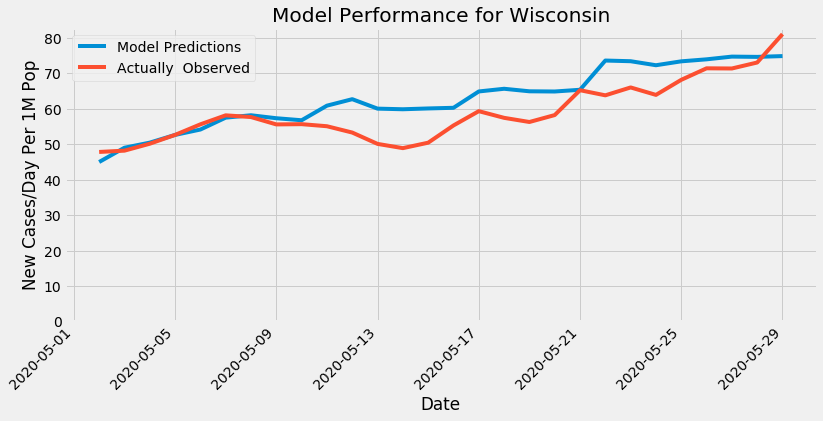

In [143]:
Prediction_Insights.plot_pred_vs_actual(save = 'images/ModelPerf{}'.format(state))

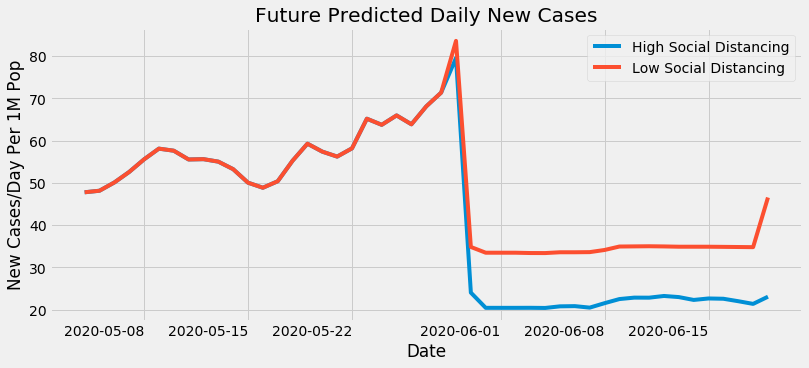

In [144]:
Prediction_Insights.forecast_to_future(save = 'images/forecastfor{}'.format(state))

In [83]:
SD_Table = Prediction_Insights.get_social_distancing_estimates(analysis = True)

In [84]:
SD_Table

,Retail/Recreation %,Grocery/Pharmacy %,Parks %,Transit Stations %,Workplaces %,Residential %,Driving %
,,,,,,,
High,50.00,74.0,78.29,43.29,46.00,121.86,57.08
Low,83.57,105.0,217.71,93.43,70.14,110.00,117.09


In [58]:
round(Similar_States_Init.make_master_pop_dens_df(), 2)

,pop_density,Recovery Factor
state,,
Alaska,1.29,3.14
Wyoming,5.84,2.19
Montana,7.47,17.17
North Dakota,11.04,2.18
South Dakota,11.91,1.55
New Mexico,17.29,1.35
Idaho,22.10,1.75
Nebraska,25.42,1.63
Nevada,28.60,1.26
